# MoleculeDiffusionTransformer: Inverse transformer model (Generate SMILES based on conditioning)

Reference:

#### Generative Discovery of Novel Chemical Designs using Diffusion Modeling and Transformer Architectures with Application to Deep Eutectic Solvents 

Rachel K. Luu1,2, Marcin Wysokowski1 , Markus J. Buehler1,3*

1 Laboratory for Atomistic and Molecular Mechanics (LAMM), Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
2 Department of Materials Science and Engineering, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
3 Center for Computational Science and Engineering, Schwarzman College of Computing, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA

mbuehler@MIT.EDU 

In [1]:
import os,sys
import math
import matplotlib.pyplot as plt 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
def exists(val):
    return val is not None

import torch

from sklearn.model_selection import train_test_split
#from tqdm import tqdm, trange
from tqdm.notebook import trange, tqdm

import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps

In [2]:
from einops import rearrange, repeat

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [4]:
import pandas as pd

from torch.utils.data import DataLoader, Dataset
import pandas as pd
import seaborn as sns
import time

In [5]:
from MoleculeDiffusion import draw_and_save, draw_and_save_set
from MoleculeDiffusion import get_data_loaders, pad_sequence_end, add_start_end_char, reverse_tokenize, is_novel
from MoleculeDiffusion import remove_start_end_token_first, remove_start_end_token

2023-04-07 06:43:18.311029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 06:43:18.466603: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
print("Torch version:", torch.__version__) 

Torch version: 1.13.1+cu116


In [7]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
#QM9: https://github.com/wengong-jin/chemprop

In [9]:
df=pd.read_csv("qm9_.csv")
 
df.describe()

,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,2.706037,75.191296,-0.239977,0.011124,0.251100,1189.527450,0.148524,31.600676,-411.543985,-411.535513,-411.534569,-411.577397
std,1.530394,8.187793,0.022131,0.046936,0.047519,279.757172,0.033274,4.062471,40.060230,40.060012,40.060012,40.060741
min,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,6.002000,-714.568061,-714.560153,-714.559209,-714.602138
25%,1.588700,70.380000,-0.252500,-0.023800,0.216300,1018.322600,0.125289,28.942000,-437.913936,-437.905942,-437.904997,-437.947682
50%,2.500000,75.500000,-0.241000,0.012000,0.249400,1147.585800,0.148329,31.555000,-417.864758,-417.857351,-417.856407,-417.895731
75%,3.636100,80.520000,-0.228700,0.049200,0.288200,1308.816600,0.171150,34.276000,-387.049166,-387.039746,-387.038802,-387.083279
max,29.556400,196.620000,-0.101700,0.193500,0.622100,3374.753200,0.273944,46.969000,-40.478930,-40.476062,-40.475117,-40.498597


In [10]:
df['smiles']

0                           C
1                           N
2                           O
3                         C#C
4                         C#N
                 ...         
133880    C1C2C3C4C5OC14C5N23
133881    C1N2C3C2C2C4OC12C34
133882    C1N2C3C4C5C2C13CN45
133883    C1N2C3C4C5CC13C2C45
133884    C1N2C3C4C5OC13C2C45
Name: smiles, Length: 133885, dtype: object

In [11]:
df['alpha']


0         13.21
1          9.46
2          6.31
3         16.28
4         12.99
          ...  
133880    69.37
133881    69.52
133882    73.60
133883    77.40
133884    69.48
Name: alpha, Length: 133885, dtype: float64

In [12]:
for col in df.columns:
    print(col)

smiles
mu
alpha
homo
lumo
gap
r2
zpve
cv
u0
u298
h298
g298


In [13]:
df.loc[0,:] [1:].shape, df.iloc[:,:].shape

((12,), (133885, 13))

In [14]:
y_data=df.iloc [:, 1: ] .to_numpy()
y_data.shape

(133885, 12)

In [15]:
# labels for y

In [16]:
col_names=df.columns[1:]
col_names 

Index(['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'cv', 'u0', 'u298',
       'h298', 'g298'],
      dtype='object')

In [17]:
col_names[1]

'alpha'

### Plotting images of SMILES

In [18]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor
from PIL import Image

rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize=20

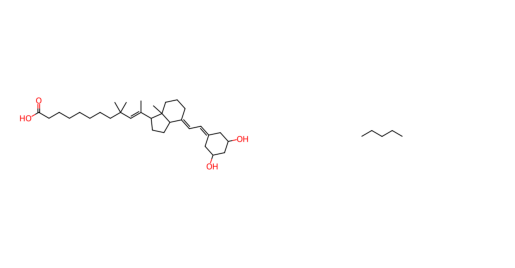

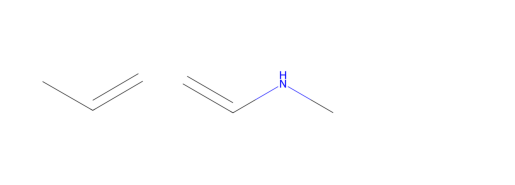

True

In [19]:
#this function draws and saves a set of SMILES codes
draw_and_save_set (smiles = ['CC(=CC(C)(C)CCCCCCCC(=O)O)C1CCC2C(=CC=C3CC(O)CC(O)C3)CCCC21C',
                                 'CCCC(C)'],
                   fname='out.png',
                    plot_title=None,
                  figsize=1,
                       mols_per_row=2,
                )

#This function compates a predicted SMILES code with a ground truth one
draw_and_save (smi = 'CC=C', GTsmile = 'CNC=C', fname='out.png', add_Hs=True)

### Normalize molecular properties

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) 
y_data = scaler.fit_transform(y_data, )  #array-like of shape (n_samples, n_features)
y_data.shape


(133885, 12)

In [21]:
context_embedding_max_length=y_data.shape[1]
context_embedding_max_length

12

In [22]:
scaler

MinMaxScaler(feature_range=(-1, 1))

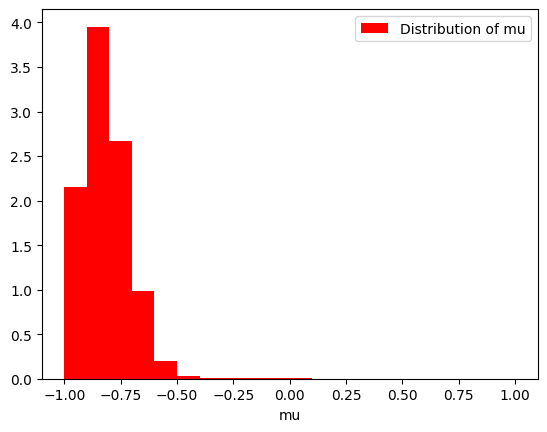

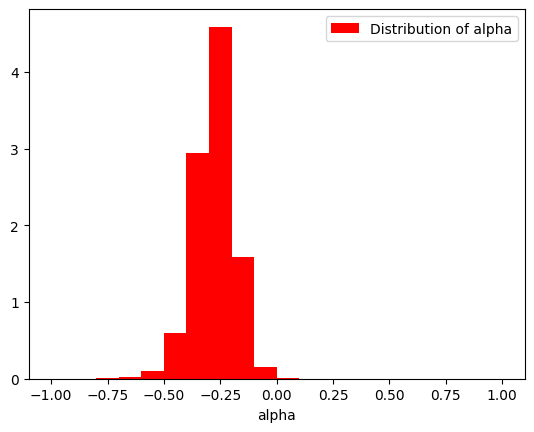

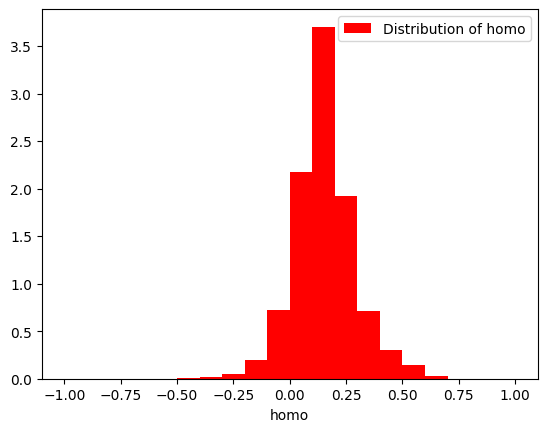

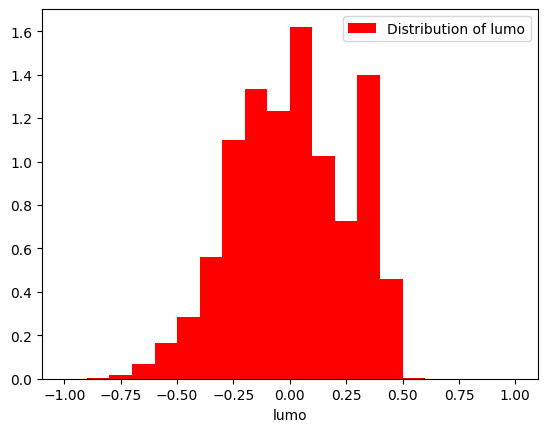

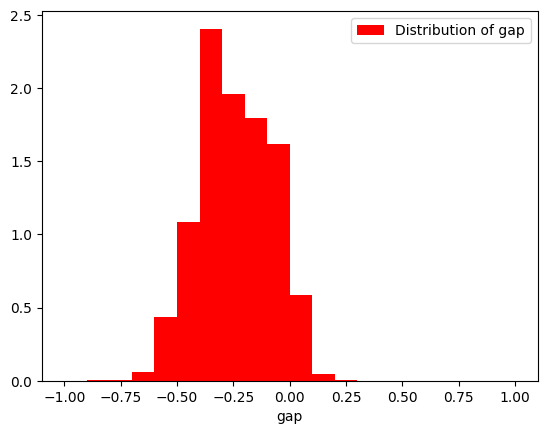

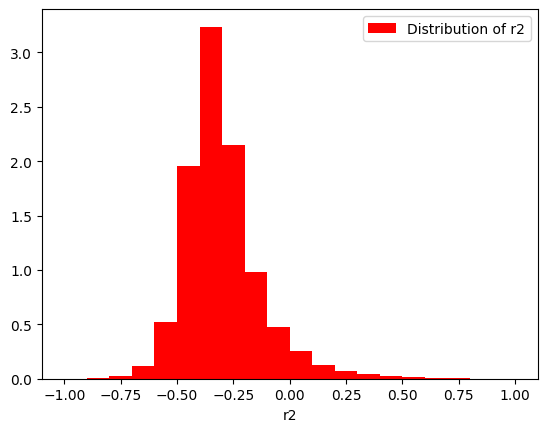

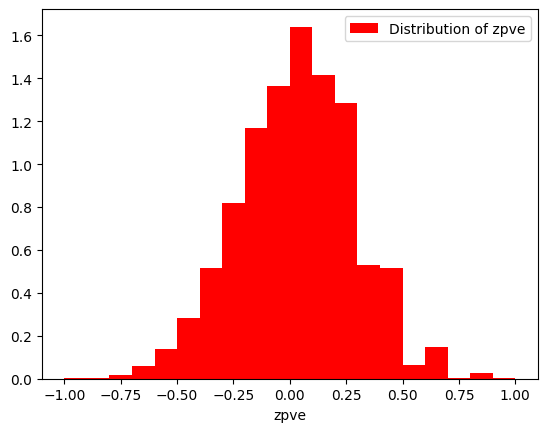

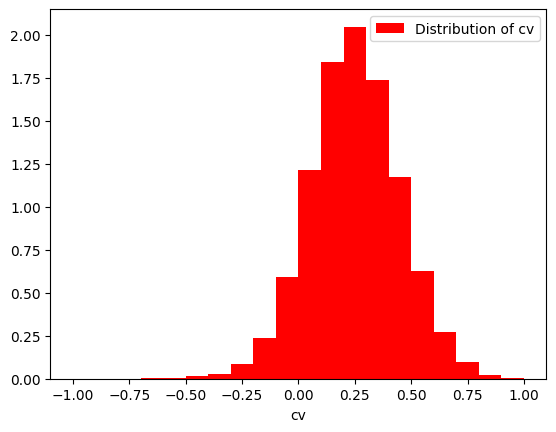

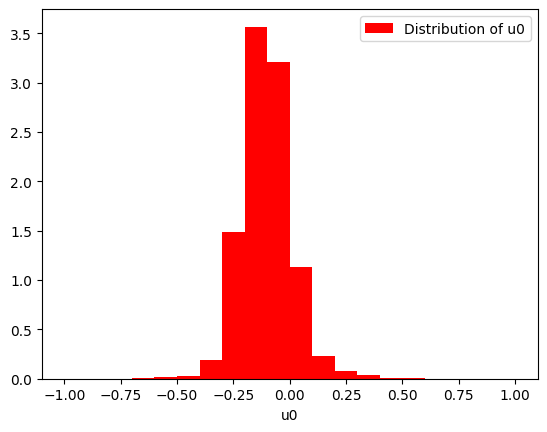

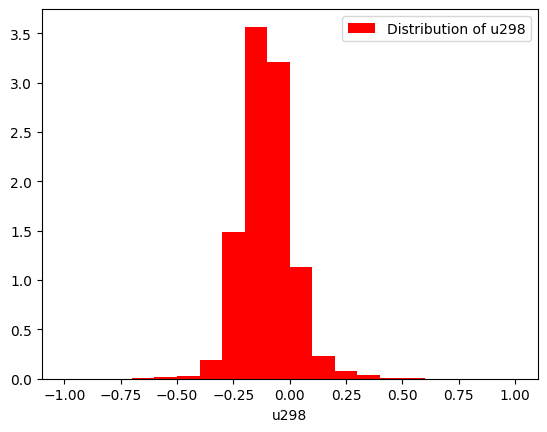

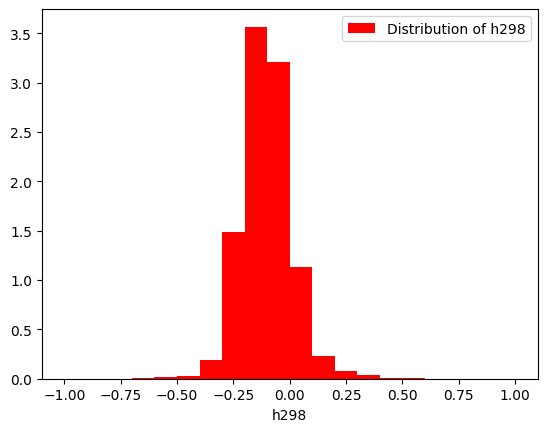

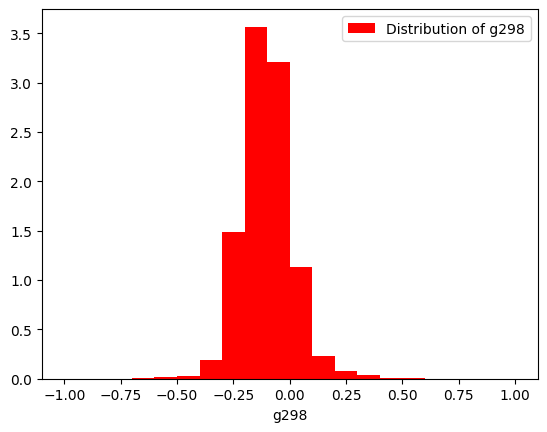

In [48]:
for i in range (len (col_names)):
    plt.hist (y_data[:,i], density=True, bins= 20, label = f'Distribution of {col_names[i]}', color='r')
    plt.xlabel (col_names[i])
    plt.legend()
    plt.show()
 

### Process SMILES strings (add start/end character, tokenize, etc.)

In [24]:
#add start and end token
start_char='@' #make sure these characters do NOT appear in the original input sequences
end_char='$'
X_data=add_start_end_char(X_data_temp= df['smiles'],
                           start_char=start_char,
                           end_char=end_char)

In [25]:
remove_start_end_token_first('@CC1(O)COC1C1CO1$fff')

'CC1(O)COC1C1CO1'

In [26]:
res = max(X_data[:], key = len)
max_length_data=len (res)
max_length=max (max_length_data, 64)

# printing result
print("Maximum length string is : " , res, "length=",max_length_data, "chosen length=", max_length)

Maximum length string is :  @c1(=O)[nH]c(=O)[nH]c(=O)[nH]1$ length= 31 chosen length= 64


In [27]:
X_data[:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [28]:
filters=''# '!"$%&()*+,-./:;<=>?[\\]^_`{|}\t\n'

tokenizer_X = Tokenizer(char_level=True, filters=filters, lower=False)
tokenizer_X.fit_on_texts(X_data)
        
X_data_tokenized = tokenizer_X.texts_to_sequences(X_data)

X_data_tokenized= sequence.pad_sequences(X_data_tokenized,  maxlen=max_length, padding='post', truncating='post')  

In [29]:
#identify token ID of start character 
start_char_token= tokenizer_X.texts_to_sequences( start_char )
start_char_token

[[4]]

In [30]:
#same for end token...
end_char_token= tokenizer_X.texts_to_sequences( end_char )
end_char_token

[[5]]

In [31]:
print ("#################################")
print ("DICTIONARY y_data")
dictt=tokenizer_X.get_config()
print (dictt)
print ("Length dictionary: ", len (dictt) )
num_words = len(tokenizer_X.word_index) + 1
num_words


#################################
DICTIONARY y_data
{'num_words': None, 'filters': '', 'lower': False, 'split': ' ', 'char_level': True, 'oov_token': None, 'document_count': 133885, 'word_counts': '{"@": 133885, "C": 787482, "$": 133885, "N": 109306, "O": 181161, "#": 37027, "=": 106335, "(": 126532, ")": 126532, "1": 270020, "c": 59074, "[": 9918, "n": 30458, "H": 8247, "]": 9918, "o": 6836, "3": 34756, "+": 1705, "-": 1808, "2": 121675, "F": 3314, "4": 5186, "5": 242}', 'word_docs': '{"$": 133885, "C": 131656, "@": 133885, "N": 74300, "O": 111215, "#": 32432, "=": 76005, "(": 92249, ")": 92249, "1": 119887, "]": 7941, "[": 7941, "c": 17698, "n": 16002, "H": 7941, "o": 6546, "-": 1808, "+": 1705, "3": 17627, "2": 60295, "F": 2163, "4": 2593, "5": 121}', 'index_docs': '{"5": 133885, "1": 131656, "4": 133885, "9": 74300, "3": 111215, "12": 32432, "10": 76005, "6": 92249, "7": 92249, "2": 119887, "16": 7941, "15": 7941, "11": 17698, "14": 16002, "17": 7941, "18": 6546, "21": 1808, "22": 

24

In [32]:
X_data_tokenized_reversed=reverse_tokenize (tokenizer_X, X_data_tokenized)

In [33]:
X_data [:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [34]:
X_data_tokenized_reversed[:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [35]:
X_data_tokenized

array([[4, 1, 5, ..., 0, 0, 0],
       [4, 9, 5, ..., 0, 0, 0],
       [4, 3, 5, ..., 0, 0, 0],
       ...,
       [4, 1, 2, ..., 0, 0, 0],
       [4, 1, 2, ..., 0, 0, 0],
       [4, 1, 2, ..., 0, 0, 0]], dtype=int32)

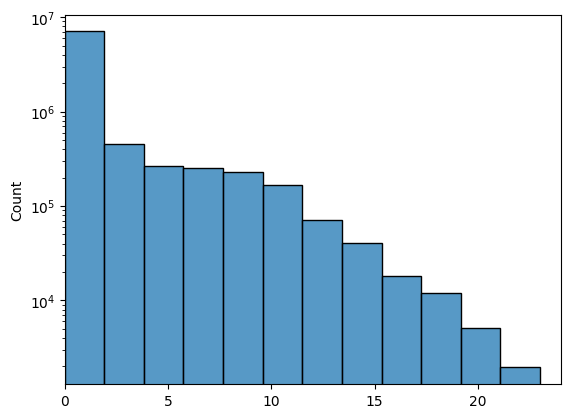

In [36]:
fig_handle =sns.histplot(np.array(X_data_tokenized).flatten(), bins=12,   log_scale=(False, True) )
fig = fig_handle.get_figure()
fig_handle.set_xlim(0, num_words)
#fig_handle.set_ylim(0, 100000)
#plt.xticks(range (1,21))
plt.show()

In [37]:
batch_size=256
train_loader,train_loader_noshuffle, test_loader= get_data_loaders (X_data_tokenized,  y_data ,  split=0.1, 
                                                                    batch_size_=batch_size)

print (f"Number of batches in training: {len (train_loader)}")

Shapes= (133885, 64), (133885, 12)
Shapes of training/test for X and y:
torch.Size([120496, 64])
torch.Size([120496, 12])
torch.Size([13389, 64])
torch.Size([13389, 12])
Number of batches in training: 471


In [38]:
#list of all known SMILES codes, used to detect novelty
ALL_SMILES=df['smiles'].values.tolist()

### Set up generative transformer model

In [39]:
prefix='./QM_generative_transformer_inverse/'
if not os.path.exists(prefix):
        os.mkdir (prefix)

In [40]:
import MoleculeDiffusion 
from MoleculeDiffusion import MoleculeTransformer,MoleculeTransformerSequence, count_parameters
from MoleculeDiffusion import train_loop_transformer, sample_loop_transformer

In [41]:
train_transformer= False
#train_transformer= True

In [42]:
context_embedding_max_length=y_data.shape[1]
logits_dim = num_words #number of tokens

model = MoleculeTransformerSequence(
        dim=128,
        depth=12,
        logits_dim=logits_dim, #number of tokens  
        dim_head = 16,
        heads = 8,
        dropout = 0.,
        ff_mult = 4,
        text_embed_dim = 16, #for sequenc conditiing
        cond_drop_prob = 0.25,
        max_text_len = context_embedding_max_length, #max length of conditioning sequence  
).cuda()

count_parameters (model)

if train_transformer:
    optimizer = optim.Adam(model.parameters() , lr=0.0002 )
else: 
    fname=f'./QM_generative_transformer_inverse/statedict_save-model-epoch_2861.pt' #lowest loss mode
    model.load_state_dict(torch.load(fname))
    print ("Loaded model")
    

----------------------------------------------------------------------------------------------------
Total parameters:  2407712  trainable parameters:  2407712
----------------------------------------------------------------------------------------------------


### Set up forward model (predicts molecular properties from SMILES)

[<class 'MoleculeDiffusion.diffusion.VDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion'>, <class 'MoleculeDiffusion.diffusion.VKDiffusion'>, <class 'MoleculeDiffusion.diffusion.KDiffusion_mod'>]
----------------------------------------------------------------------------------------------------
Total parameters:  18322684  trainable parameters:  18322684
----------------------------------------------------------------------------------------------------


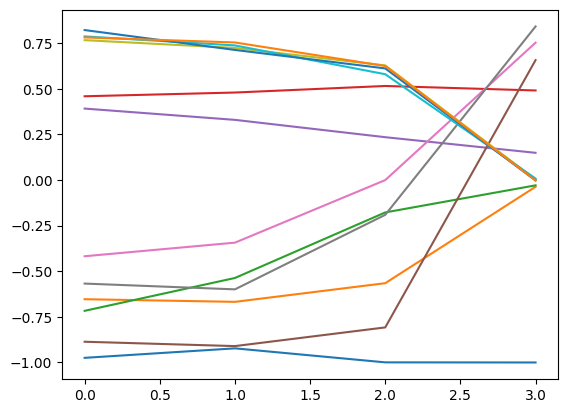

In [43]:
pred_dim=1
max_length_forward=64
X_norm_factor=21.

from MoleculeDiffusion import QMDiffusionForward,predict_properties_from_SMILES, ADPM2Sampler
 
context_embedding_max_length=y_data.shape[1]
model_forward =QMDiffusionForward( 
                max_length=max_length_forward,#context_embedding_max_length,#length of predicted data
                pred_dim=pred_dim,
                channels=64,
                unet_type='cfg', #'base', #'cfg',
                context_embedding_max_length=max_length_forward,  #length of conditioning 
                pos_emb_fourier=True,
                pos_emb_fourier_add=False,
                text_embed_dim = 64,
                embed_dim_position=64,
                )  .to(device)  

count_parameters (model_forward)

fname=f'./diffusion_forward/statedict_save-model-epoch_78.pt' #lowest loss mode
model_forward.load_state_dict(torch.load(fname))

res, _=predict_properties_from_SMILES (model_forward,device, SMILES=['C',
                                                                     'CCC',
                                                                     'CCCCCC',
                                                                     'CCCCCCCCC'], 
                X_norm_factor=X_norm_factor,
                scaler=scaler,
                tokenizer_X=tokenizer_X,
                 
                cond_scales=[1.], #list of cond scales - each sampled...
                
                timesteps=100,
                flag=0, 
                clamp=False,
                 
                draw_molecules=False,
                draw_all=False,
                mols_per_row=8,max_length = 64,
                                       
                context_embedding_max_length=12, 
               )

plt.plot (res[:,:])
plt.show()

In [44]:
start_char_token,end_char_token

([[4]], [[5]])

In [45]:
X_norm_factor

21.0

  0%|          | 0/63 [00:00<?, ?it/s]

(256, 64) torch.Size([256, 64])


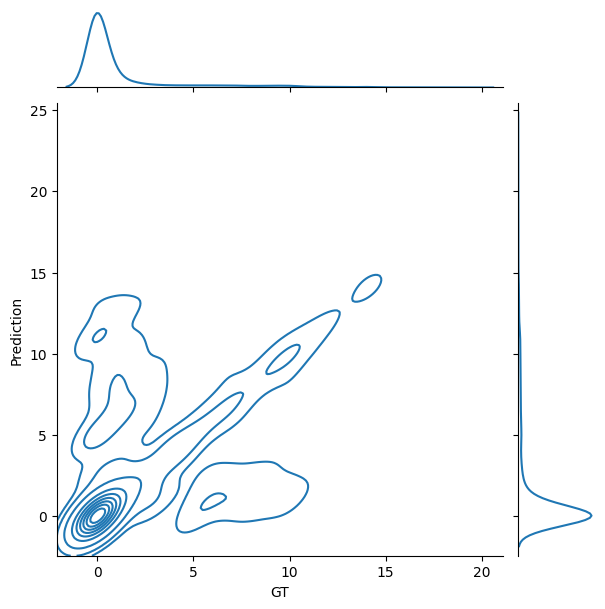

sample result (256, 64) GT shape (256, 64), conditioning: torch.Size([256, 12])
Result as SMILES:  ['@CC1C(=O)C2OC12CO$', '@OCCC1CC1C1CO1$', '@NC(C#N)C1=CN=NN1$', '@CC1CCC2(CC)CC12$', '@CC1NC11=NC(C)C1N$', '@OC1CC11COCC1ON1$C', '@CC1C2OC1C(C)=C2$', '@C#CCC1=NCCO1$', '@OC1(CC=CC1)C=O$', '@OC1CC23CCC2(C1)N3$', '@c1(=O)c(=O)onc(o1)N$', '@CC12OC3(C=NC1N)C23$', '@CC1C2OCC(=NO)C12$]C$C$', '@CC1C2C3C2N2C1C3=O$', '@CC(NCC#N)NC=N$', '@COCC1CCC(C)O1$C$C$C$C$', '@NC(=+CO)C(=O)N$', '@OC1C2OC3OCC2O12$C$C$C$CCC', '@CC#CC(=O)NCC$', '@FC1=NNC(=N)C(=N)N1-)N$', '@CC12CC3CC3C1(CO1)C23$', '@C1OCC2=CCCCC12$', '@c1([nC(=O)nc(n1)O)N5$', '@CCC1CC2(CN2)C1O$', '@NC1(CNC(=O)C1)C#C$', '@CC#CC(=NO)C#C$c$Oc$Oc$Oc$Occc4c$O-Oc$Oc$O-]H4c$Oc', '@CC(O)(C#C)C#CC$c$', '@N=C1C=CN=CN==C1$', '@OCC1CCC=C1C#C3$OcOcccccccc1c(1cO1O1cc(1c(', '@CN1CC2(CN2)C1=O$', '@C1C(=O1CN)c(=Nn-3)C$', '@CC1CC(=O)OC1C$', '@c1c([nH]c(n1)O)C2CC2$', '@c1c[n@c2c1CC(=O)N2$', '@CN1C2CC=CC(O)C12$', '@OC2C(O)CO3CC3O2$', '@CN1CC1(C#C)C1CO21$', '@CCN1CC1C

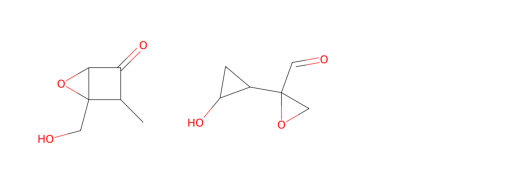

Properties:  [[-0.744222   -0.27858853  0.18201892  0.00574245 -0.26406658 -0.20168036
  -0.09535987  0.27744994 -0.09936214 -0.10317727 -0.09707971 -0.10537843]
 [-0.77945364 -0.30764562 -0.03552813 -0.2997598  -0.32119218 -0.35006106
  -0.21252008  0.17496407 -0.13173306 -0.13320707 -0.12892146 -0.13028036]]  unscaled:  [[ 3.77993870e+00  7.49559097e+01 -2.35399008e-01  1.03080459e-02
   2.44460106e-01  1.35848193e+03  1.32646412e-01  3.21686478e+01
  -4.11012970e+02 -4.12293213e+02 -4.10237091e+02 -4.13068359e+02]
 [ 3.25927830e+00  7.21909790e+01 -2.70957083e-01 -4.59807441e-02
   2.27393836e-01  1.10951746e+03  1.17533155e-01  3.00693760e+01
  -4.21923431e+02 -4.22414490e+02 -4.20969116e+02 -4.21461609e+02]]
R2 score=  0.7236642951695003


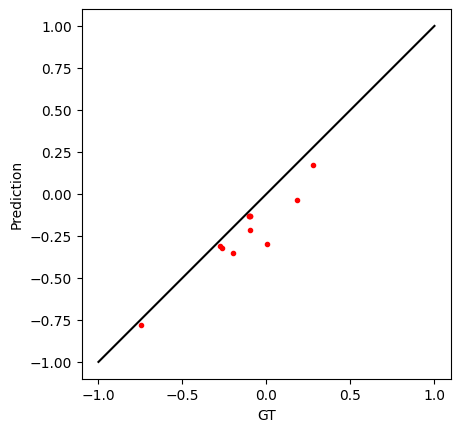

OCCC1CC1C1CO1 OCC1OC1CC1CC1
SMILES result= OCCC1CC1C1CO1 GT:  OCC1OC1CC1CC1  is novel:  False


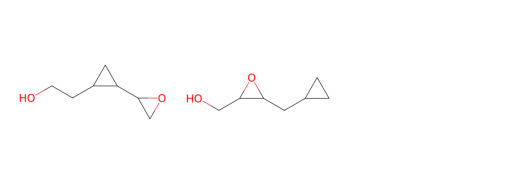

Properties:  [[-0.8242241  -0.22163138  0.08076505  0.36024314  0.02073461 -0.2815393
   0.30568722  0.41427058 -0.10394003 -0.101797   -0.10731909 -0.10172495]
 [-0.862743   -0.20786816  0.05942931  0.3924592   0.0469268   0.03989909
   0.3379203   0.44599837 -0.11846461 -0.11227125 -0.10895725 -0.10966188]]  unscaled:  [[ 2.5976512e+00  8.0375671e+01 -2.5194895e-01  7.5624801e-02
   3.2954445e-01  1.2244885e+03  1.8438008e-01  3.4971210e+01
  -4.1255591e+02 -4.1182797e+02 -4.1368820e+02 -4.1183691e+02]
 [ 2.0284111e+00  8.1685303e+01 -2.5543627e-01  8.1560612e-02
   3.3736941e-01  1.7638224e+03  1.8853803e-01  3.5621109e+01
  -4.1745135e+02 -4.1535822e+02 -4.1424033e+02 -4.1451208e+02]]
R2 score=  0.9106254709752558


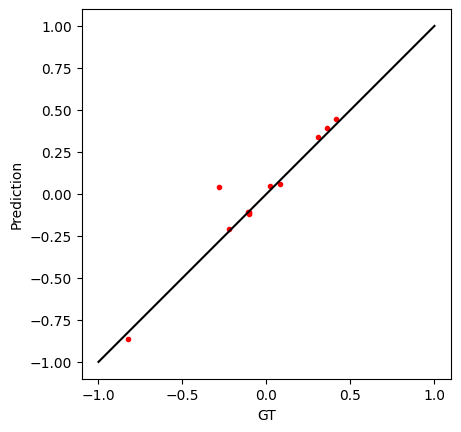

NC(C#N)C1=CN=NN1 NC(C#N)C1=NNC=N1
SMILES result= NC(C#N)C1=CN=NN1 GT:  NC(C#N)C1=NNC=N1  is novel:  False


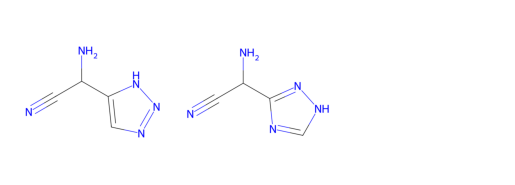

Properties:  [[-0.6555337  -0.28709552  0.23381238  0.00729822 -0.28748947 -0.35649812
  -0.22976592  0.14403039 -0.07428353 -0.07468908 -0.06984019 -0.0732194 ]
 [-0.6506366  -0.31556523  0.20992589  0.04033951 -0.25420463 -0.3961206
  -0.27721372  0.10809207 -0.09949619 -0.09994301 -0.0918118  -0.10004903]]  unscaled:  [[ 5.0905924e+00  7.4146431e+01 -2.2693338e-01  1.0594697e-02
   2.3746252e-01  1.0987168e+03  1.1530850e-01  2.9435747e+01
  -4.0256033e+02 -4.0269147e+02 -4.0105621e+02 -4.0222913e+02]
 [ 5.1629620e+00  7.1437393e+01 -2.3083761e-01  1.6682554e-02
   2.4740636e-01  1.0322352e+03  1.0918790e-01  2.8699604e+01
  -4.1105814e+02 -4.1120312e+02 -4.0846161e+02 -4.1127206e+02]]
R2 score=  0.9820620062732364


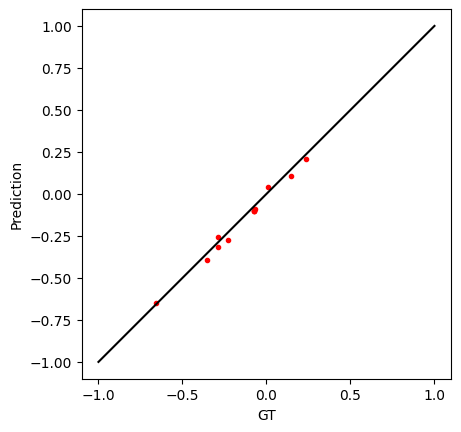

CC1CCC2(CC)CC12 CC1CC11CCCCC1
SMILES result= CC1CCC2(CC)CC12 GT:  CC1CC11CCCCC1  is novel:  True


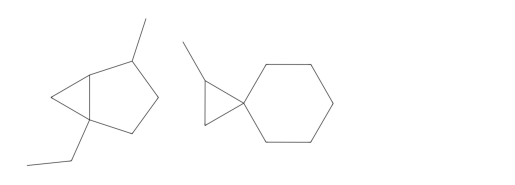

Properties:  [[-0.9996892  -0.04760211 -0.23335671  0.4245533   0.23337203 -0.07323031
   0.76352113  0.64796543  0.11119055  0.11503831  0.10881236  0.10528652]
 [-0.8543007  -0.07116291  0.26272944 -0.25283983 -0.4627734  -0.2572807
   0.23196751  0.29240784  0.05472026  0.05010094  0.05875803  0.05269999]]  unscaled:  [[ 4.5927484e-03  9.6935417e+01 -3.0329216e-01  8.7473944e-02
   3.9306989e-01  1.5740054e+03  2.4343906e-01  3.9758099e+01
  -3.4004733e+02 -3.3874536e+02 -3.4084280e+02 -3.4206335e+02]
 [ 2.1531737e+00  9.4693497e+01 -2.2220688e-01 -3.7335739e-02
   1.8509644e-01  1.2651914e+03  1.7487051e-01  3.2475037e+01
  -3.5908032e+02 -3.6063199e+02 -3.5771323e+02 -3.5978775e+02]]
R2 score=  0.25462434214127927


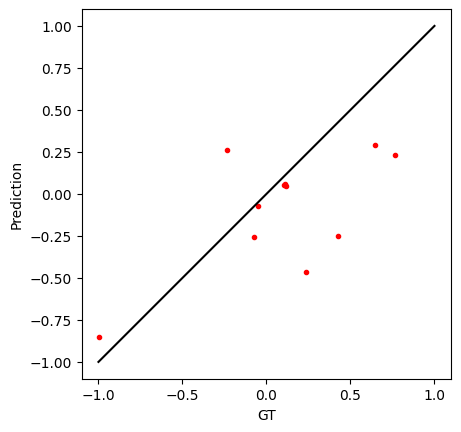

CC1NC11=NC(C)C1N CC1=C(CNC(=O)C1)C
SMILES result= CC1NC11=NC(C)C1N GT:  CC1=C(CNC(=O)C1)C  is novel:  True


[06:28:37] Explicit valence for atom # 3 C, 5, is greater than permitted


Properties:  [[-7.3473543e-01 -1.3820414e-01  7.3068753e-02 -3.5217914e-01
  -4.2280647e-01 -1.7342937e-01 -4.2199609e-01  2.3707710e-01
  -3.9398982e-04 -2.0431117e-03 -2.3273092e-03  1.1743908e-03]
 [-8.3866370e-01 -8.1213169e-02  4.4871461e-02 -3.9231491e-01
  -4.2195937e-01  3.9526578e-02 -4.2169046e-01  1.9203053e-01
  -8.1785908e-03 -1.2135620e-02 -1.2687352e-02 -9.6689053e-03]]  unscaled:  [[ 3.9201329e+00  8.8314186e+01 -2.5320691e-01 -5.5639006e-02
   1.9703656e-01  1.4058835e+03  9.0511478e-02  3.1341669e+01
  -3.7765628e+02 -3.7820673e+02 -3.7830154e+02 -3.7715454e+02]
 [ 2.3842602e+00  9.3737160e+01 -2.5781575e-01 -6.3034020e-02
   1.9728963e-01  1.7631974e+03  9.0550907e-02  3.0418957e+01
  -3.8028006e+02 -3.8160834e+02 -3.8179333e+02 -3.8080927e+02]]
R2 score=  0.921569562847733


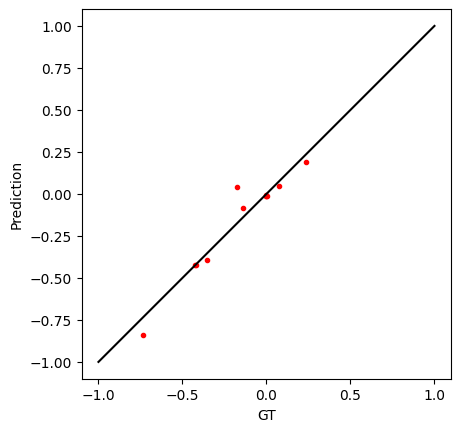

OC1CC11COCC1ON1 CC1(O)COC1C1CO1
SMILES result= OC1CC11COCC1ON1 GT:  CC1(O)COC1C1CO1  is novel:  True


[06:28:45] SMILES Parse Error: unclosed ring for input: 'OC1CC11COCC1ON1'


Properties:  [[-0.8650935  -0.2552016   0.21519426  0.33559242 -0.06433885 -0.23053284
   0.2124771   0.31607053 -0.12104888 -0.11946717 -0.12006141 -0.11727462]
 [-0.78743654 -0.30988488  0.18415974 -0.21940914 -0.41388038 -0.23740771
  -0.11240997  0.2545907  -0.21579666 -0.2079555  -0.20875601 -0.2120324 ]]  unscaled:  [[ 1.9936748e+00  7.7181290e+01 -2.2997651e-01  7.1082905e-02
   3.0412880e-01  1.3100710e+03  1.7235629e-01  3.2959732e+01
  -4.1832236e+02 -4.1778357e+02 -4.1798288e+02 -4.1707800e+02]
 [ 3.1413052e+00  7.1977905e+01 -2.3504908e-01 -3.1176133e-02
   1.9970323e-01  1.2985359e+03  1.3044700e-01  3.1700409e+01
  -4.5025656e+02 -4.4760785e+02 -4.4787674e+02 -4.4901624e+02]]
R2 score=  0.5043570081907366


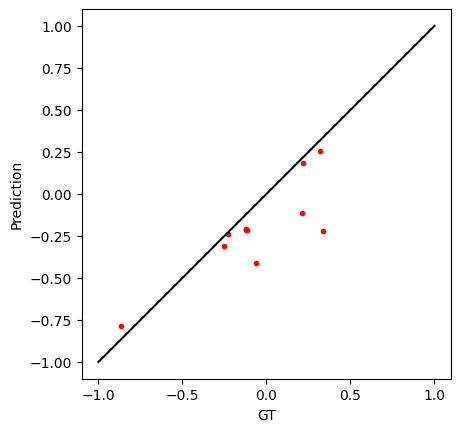

CC1C2OC1C(C)=C2 CC1C2OC1C(C)=C2
SMILES result= CC1C2OC1C(C)=C2 GT:  CC1C2OC1C(C)=C2  is novel:  False


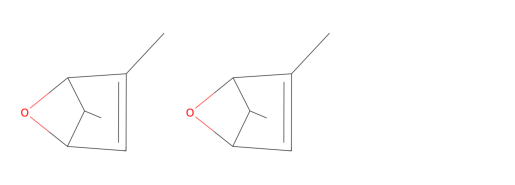

Properties:  [[-0.65490466 -0.18996726  0.27857983 -0.0628935  -0.35361484 -0.31303182
  -0.09736568  0.4336137  -0.01121917 -0.02098121 -0.01404772 -0.01990215]
 [-0.6514718  -0.16147254  0.30868617 -0.03577412 -0.35444102 -0.29583082
   0.00111992  0.3639507   0.03685402  0.02895706  0.03291626  0.037771  ]]  unscaled:  [[ 5.0998878e+00  8.3388664e+01 -2.1961612e-01 -2.3381277e-03
   2.1770756e-01  1.1716479e+03  1.3238767e-01  3.5367424e+01
  -3.8130487e+02 -3.8458966e+02 -3.8225183e+02 -3.8425842e+02]
 [ 5.1506195e+00  8.6100075e+01 -2.1469525e-01  2.6586179e-03
   2.1746074e-01  1.2005092e+03  1.4509197e-01  3.3940483e+01
  -3.6510205e+02 -3.6775833e+02 -3.6642300e+02 -3.6481961e+02]]
R2 score=  0.9685983947231901


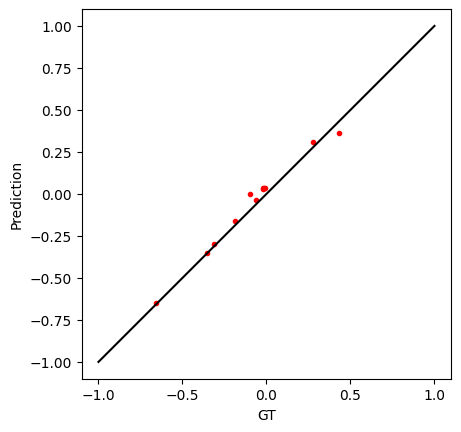

C#CCC1=NCCO1 C#CCC1CN=CO1
SMILES result= C#CCC1=NCCO1 GT:  C#CCC1CN=CO1  is novel:  False


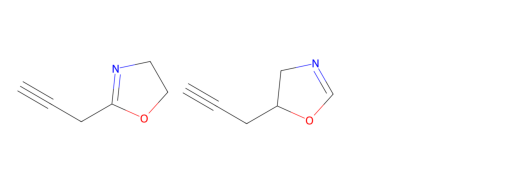

Properties:  [[-0.9152682  -0.31843135  0.01061724 -0.01163696 -0.18850482 -0.36575758
  -0.43182838  0.10845237  0.13805799  0.1443412   0.14183286  0.14275874]
 [-0.8907693  -0.33721423  0.02772989  0.03098129 -0.16704154 -0.37444687
  -0.4605974   0.06183916  0.16301237  0.18282534  0.18344977  0.17493375]]  unscaled:  [[ 1.2521838e+00  7.1164665e+01 -2.6341459e-01  7.1058893e-03
   2.6703420e-01  1.0831805e+03  8.9243151e-02  2.8706985e+01
  -3.3099179e+02 -3.2886905e+02 -3.2971353e+02 -3.2943329e+02]
 [ 1.6142331e+00  6.9377380e+01 -2.6061755e-01  1.4958303e-02
   2.7344635e-01  1.0686011e+03  8.5532054e-02  2.7752184e+01
  -3.2258105e+02 -3.1589828e+02 -3.1568686e+02 -3.1858862e+02]]
R2 score=  0.9903477126524454


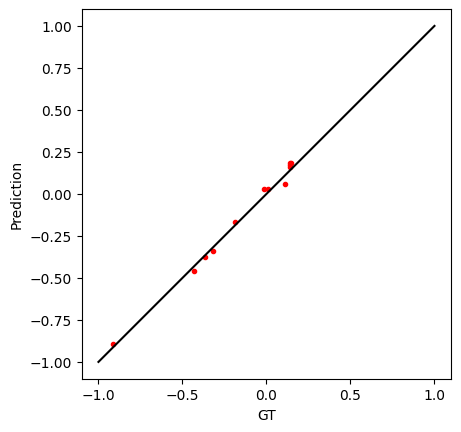

OC1(CC=CC1)C=O OC1(CCC=C1)C=O
SMILES result= OC1(CC=CC1)C=O GT:  OC1(CCC=C1)C=O  is novel:  False


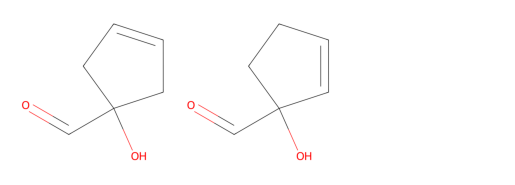

Properties:  [[-0.7717996  -0.36145753  0.10110765 -0.08081383 -0.28331733 -0.45160288
  -0.4119854   0.19411215  0.04823197  0.03684188  0.04457141  0.04424051]
 [-0.9078841  -0.32374996  0.25636676 -0.01736107 -0.31773597 -0.4002679
  -0.32135144  0.13210697  0.05397122  0.04342188  0.04315235  0.05022801]]  unscaled:  [[ 3.3723907e+00  6.7070511e+01 -2.4862395e-01 -5.6399484e-03
   2.3870894e-01  9.3914282e+02  9.1802828e-02  3.0461597e+01
  -3.6126718e+02 -3.6510086e+02 -3.6249472e+02 -3.6263901e+02]
 [ 1.3613069e+00  7.0658569e+01 -2.2324686e-01  6.0512233e-03
   2.2842638e-01  1.0252766e+03  1.0349429e-01  2.9191513e+01
  -3.5933276e+02 -3.6288312e+02 -3.6297299e+02 -3.6062094e+02]]
R2 score=  0.9321387165441689


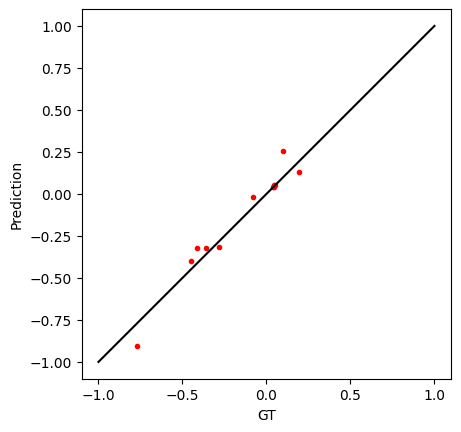

OC1CC23CCC2(C1)N3 OCC12CC1CN1CC21
SMILES result= OC1CC23CCC2(C1)N3 GT:  OCC12CC1CN1CC21  is novel:  False


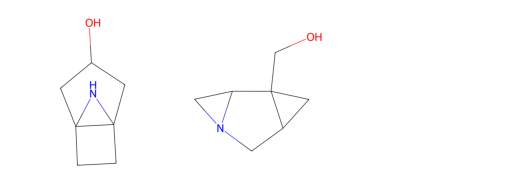

Properties:  [[-0.7988755  -0.23601043  0.27441263 -0.15326558 -0.39429444 -0.28359592
  -0.1731793   0.2567231  -0.09625416 -0.09192444 -0.09403157 -0.09920358]
 [-0.8184064  -0.26262894  0.29772642  0.01658309 -0.31406713 -0.43206125
   0.05354808  0.0823943  -0.0416467  -0.03284626 -0.03505924 -0.03866561]]  unscaled:  [[ 2.97225785e+00  7.90074234e+01 -2.20297247e-01 -1.89891830e-02
   2.05554530e-01  1.22103772e+03  1.22607976e-01  3.17440891e+01
  -4.09965424e+02 -4.08500519e+02 -4.09209747e+02 -4.10987122e+02]
 [ 2.68362641e+00  7.64745483e+01 -2.16486618e-01  1.23054329e-02
   2.29522452e-01  9.71931213e+02  1.51855007e-01  2.81732254e+01
  -3.91560303e+02 -3.88588654e+02 -3.89333618e+02 -3.90582672e+02]]
R2 score=  0.8211991931816447


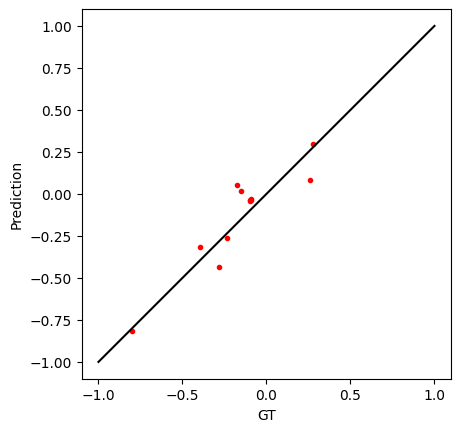

c1(=O)c(=O)onc(o1)N OC1=NOC(=O)C(=N)O1
SMILES result= c1(=O)c(=O)onc(o1)N GT:  OC1=NOC(=O)C(=N)O1  is novel:  False


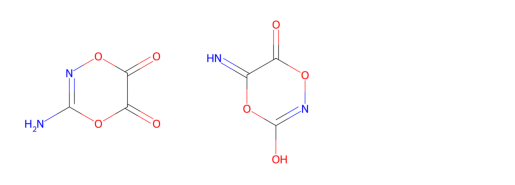

Properties:  [[-0.7526942  -0.38923788 -0.4370667  -0.5619055  -0.24400818 -0.38807657
  -0.70324856  0.08134025 -0.19627722 -0.20211208 -0.19793534 -0.18608116]
 [-0.66935426 -0.28618932  0.55233186  0.06287997 -0.43409517 -0.3436999
  -0.21412483  0.13927592 -0.17309774 -0.16722597 -0.17064984 -0.16742805]]  unscaled:  [[ 3.6547346e+00  6.4427071e+01 -3.3658856e-01 -9.4281092e-02
   2.5045255e-01  1.0457322e+03  5.4230895e-02  2.8151634e+01
  -4.4367764e+02 -4.4563837e+02 -4.4422968e+02 -4.4026938e+02]
 [ 4.8863487e+00  7.4232658e+01 -1.7487136e-01  2.0835634e-02
   1.9366406e-01  1.1201907e+03  1.1732615e-01  2.9338358e+01
  -4.3586514e+02 -4.3388028e+02 -4.3503333e+02 -4.3398230e+02]]
R2 score=  -1.6298489424898999


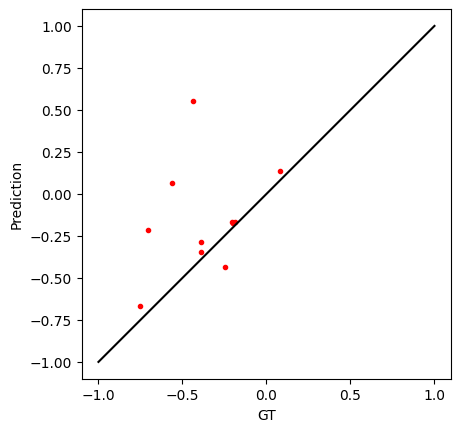

CC12OC3(C=NC1N)C23 OC1CC11C2CC2C1=O
SMILES result= CC12OC3(C=NC1N)C23 GT:  OC1CC11C2CC2C1=O  is novel:  True


[06:29:34] SMILES Parse Error: ring closure 3 duplicates bond between atom 3 and atom 8 for input: 'CC12OC3(C=NC1N)C23'


Properties:  [[-0.74077225 -0.21465077  0.02511721 -0.09609008 -0.2349104  -0.27442238
  -0.14080375  0.21043473 -0.01569457 -0.01454697 -0.01505032 -0.01504419]
 [-0.6640078  -0.26572636  0.15997374  0.02775324 -0.23362777 -0.34618327
  -0.19779082  0.06387868 -0.03857499 -0.03192289 -0.03211997 -0.02825604]]  unscaled:  [[ 3.8309195e+00  8.1039909e+01 -2.6104459e-01 -8.4545966e-03
   2.5317052e-01  1.2364298e+03  1.2678431e-01  3.0795940e+01
  -3.8281326e+02 -3.8242105e+02 -3.8258978e+02 -3.8262106e+02]
 [ 4.9653602e+00  7.6179810e+01 -2.3900229e-01  1.4363534e-02
   2.5355369e-01  1.1160239e+03  1.1943317e-01  2.7793959e+01
  -3.9052496e+02 -3.8827750e+02 -3.8834293e+02 -3.8707413e+02]]
R2 score=  0.8792233145312759


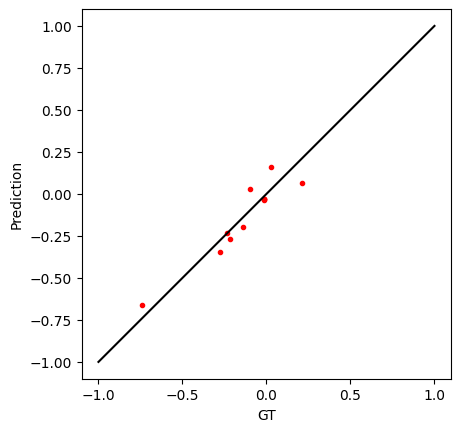

CC1C2OCC(=NO)C12 CN1CC(=N)N(C)C1=O
SMILES result= CC1C2OCC(=NO)C12 GT:  CN1CC(=N)N(C)C1=O  is novel:  False


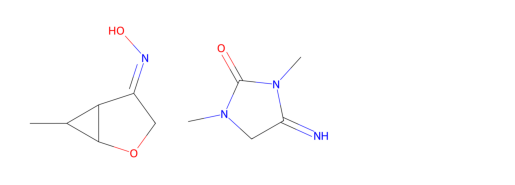

Properties:  [[-0.77720803 -0.16206385  0.04382559 -0.3867575  -0.42249086 -0.31946087
  -0.4077402   0.1527008  -0.00742948 -0.00803314 -0.00433772 -0.00604447]
 [-0.72035867 -0.20106769  0.13335037 -0.36426607 -0.4802701  -0.3119148
  -0.159821    0.1859855  -0.02207485 -0.02477729 -0.01883761 -0.02466317]]  unscaled:  [[ 3.2924643e+00  8.6043816e+01 -2.5798672e-01 -6.2010068e-02
   1.9713084e-01  1.1608607e+03  9.2350438e-02  2.9613346e+01
  -3.8002756e+02 -3.8022562e+02 -3.7897916e+02 -3.7958765e+02]
 [ 4.1325955e+00  8.2332405e+01 -2.4335387e-01 -5.7866022e-02
   1.7986931e-01  1.1735221e+03  1.2433115e-01  3.0295135e+01
  -3.8496371e+02 -3.8586911e+02 -3.8386624e+02 -3.8586313e+02]]
R2 score=  0.900793692833236


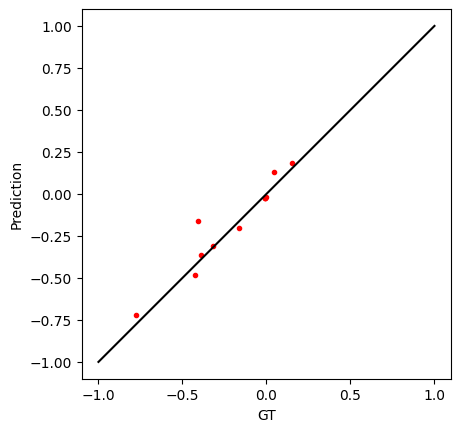

CC1C2C3C2N2C1C3=O OC1CC2C3C4C1C2N34
SMILES result= CC1C2C3C2N2C1C3=O GT:  OC1CC2C3C4C1C2N34  is novel:  True


[06:29:51] SMILES Parse Error: unclosed ring for input: 'CC1C2C3C2N2C1C3=O'


Properties:  [[-0.8468299  -0.3274357   0.11866181  0.32091236 -0.04059293 -0.50137
  -0.05011438 -0.05314534 -0.05645756 -0.06001246 -0.05436326 -0.05978737]
 [-0.7500751  -0.27533302  0.16834201  0.057008   -0.21823166 -0.44045112
  -0.04727839  0.08251717 -0.0098271  -0.01009424 -0.00873708 -0.01041901]]  unscaled:  [[ 2.2635784e+00  7.0307861e+01 -2.4575473e-01  6.8378106e-02
   3.1122288e-01  8.5563971e+02  1.3848291e-01  2.5396898e+01
  -3.9655222e+02 -3.9774484e+02 -3.9583987e+02 -3.9770181e+02]
 [ 3.6934402e+00  7.5265686e+01 -2.3763449e-01  1.9753722e-02
   2.5815329e-01  9.5785413e+02  1.3884875e-01  2.8175739e+01
  -3.8083563e+02 -3.8092032e+02 -3.8046191e+02 -3.8106213e+02]]
R2 score=  0.8524920855192957


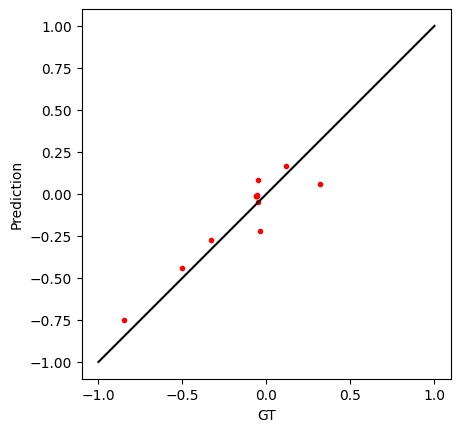

CC(NCC#N)NC=N CC1(O)CC1NCC#N
SMILES result= CC(NCC#N)NC=N GT:  CC1(O)CC1NCC#N  is novel:  True


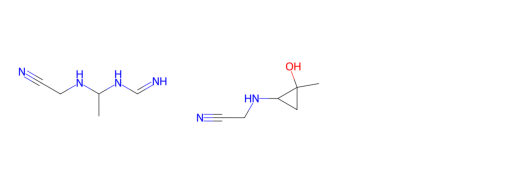

Properties:  [[-0.70143294 -0.34403875  0.01585626 -0.00649765 -0.16846636 -0.50804204
  -0.16813129  0.01836144  0.07299471  0.07578044  0.07231139  0.0775619 ]
 [-0.745949   -0.14674844  0.31545103  0.00103441 -0.34314343 -0.26071033
  -0.04638721  0.21450844  0.00737931  0.00323662  0.00988299  0.00193665]]  unscaled:  [[ 4.4122839e+00  6.8727997e+01 -2.6255828e-01  8.0528082e-03
   2.7302065e-01  8.4444489e+02  1.2325916e-01  2.6861607e+01
  -3.5292102e+02 -3.5197690e+02 -3.5314520e+02 -3.5140799e+02]
 [ 3.7544169e+00  8.7501152e+01 -2.1358952e-01  9.4405916e-03
   2.2083589e-01  1.2594370e+03  1.3896371e-01  3.0879383e+01
  -3.7503635e+02 -3.7642722e+02 -3.7418619e+02 -3.7689761e+02]]
R2 score=  0.6038100379412048


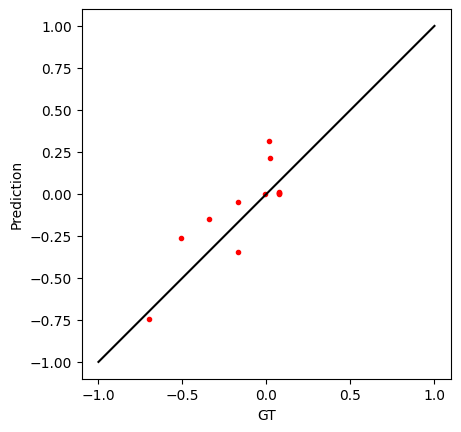

COCC1CCC(C)O1 CCOC1CC(C)CO1
SMILES result= COCC1CCC(C)O1 GT:  CCOC1CC(C)CO1  is novel:  False


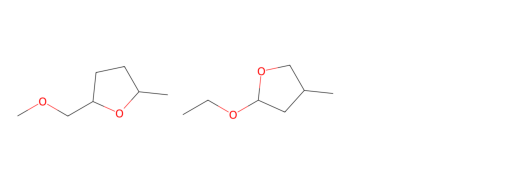

Properties:  [[-0.9981556  -0.14980286  0.2198638   0.39258316 -0.03836907 -0.03714931
   0.4387756   0.51579714 -0.0620796  -0.05112911 -0.04849565 -0.0527332 ]
 [-0.8726875  -0.18867595  0.18886074  0.35920337 -0.03653238 -0.11953413
   0.44089705  0.400753   -0.07709391 -0.06727102 -0.06763823 -0.07075553]]  unscaled:  [[ 2.7257003e-02  8.7210510e+01 -2.2921327e-01  8.1583448e-02
   3.1188723e-01  1.6345447e+03  2.0154803e-01  3.7050831e+01
  -3.9844708e+02 -3.9475076e+02 -3.9386221e+02 -3.9532419e+02]
 [ 1.8814493e+00  8.3511543e+01 -2.3428072e-01  7.5433224e-02
   3.1243595e-01  1.4963131e+03  2.0182168e-01  3.4694324e+01
  -4.0350757e+02 -4.0019125e+02 -4.0031409e+02 -4.0139865e+02]]
R2 score=  0.9760544440513184


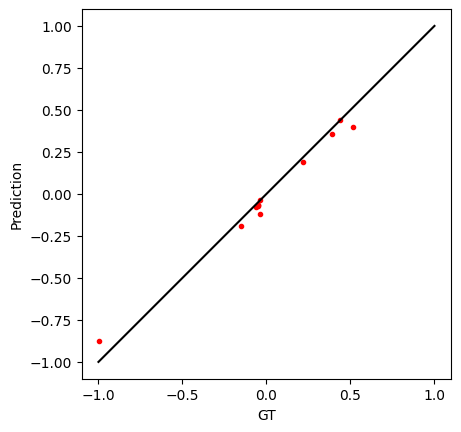

NC(=+CO)C(=O)N NC(=N)C1(CO1)C#N
SMILES result= NC(=+CO)C(=O)N GT:  NC(=N)C1(CO1)C#N  is novel:  True


[06:30:16] SMILES Parse Error: syntax error while parsing: NC(=+CO)C(=O)N
[06:30:16] SMILES Parse Error: Failed parsing SMILES 'NC(=+CO)C(=O)N' for input: 'NC(=+CO)C(=O)N'


Properties:  [[-0.72404456 -0.36104363  0.13400015  0.02429779 -0.21281324 -0.39481986
  -0.13689023  0.07399224 -0.12218834 -0.12203997 -0.12148961 -0.12506384]
 [-0.7529179  -0.24967714  0.2058613  -0.21155863 -0.40767574 -0.13152874
  -0.25685287  0.2088377  -0.18244682 -0.18798739 -0.19270578 -0.18937021]]  unscaled:  [[ 4.0781245e+00  6.7109894e+01 -2.4324769e-01  1.3726869e-02
   2.5977203e-01  1.0344177e+03  1.2728915e-01  2.8001120e+01
  -4.1870642e+02 -4.1865070e+02 -4.1846426e+02 -4.1970334e+02]
 [ 3.6514289e+00  7.7706970e+01 -2.3150198e-01 -2.9729676e-02
   2.0155688e-01  1.4761876e+03  1.1181438e-01  3.0763227e+01
  -4.3901620e+02 -4.4087775e+02 -4.4246713e+02 -4.4137793e+02]]
R2 score=  0.611886441804895


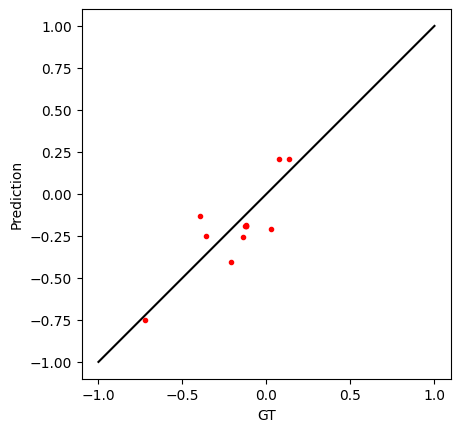

OC1C2OC3OCC2O12 C1C2OCOC1C1OC21
SMILES result= OC1C2OC3OCC2O12 GT:  C1C2OCOC1C1OC21  is novel:  True


[06:30:23] SMILES Parse Error: unclosed ring for input: 'OC1C2OC3OCC2O12'


Properties:  [[-0.7596434  -0.2923755   0.12999378 -0.22645383 -0.373021   -0.28869292
  -0.02808269  0.21839511 -0.16092107 -0.15687543 -0.15139604 -0.1570075 ]
 [-0.8269431  -0.37247202  0.09740087  0.27258432 -0.03941701 -0.4054395
  -0.12748669  0.05442296 -0.23584396 -0.2416947  -0.24363552 -0.24447615]]  unscaled:  [[ 3.55203819e+00  7.36440048e+01 -2.43902504e-01 -3.24741155e-02
   2.11909980e-01  1.21248560e+03  1.41324937e-01  3.09589958e+01
  -4.31761078e+02 -4.30391693e+02 -4.28543976e+02 -4.30470032e+02]
 [ 2.55746937e+00  6.60224304e+01 -2.49229833e-01  5.94736598e-02
   3.11574161e-01  1.01659924e+03  1.28502160e-01  2.76002731e+01
  -4.57013397e+02 -4.58979370e+02 -4.59632568e+02 -4.59951477e+02]]
R2 score=  0.33511196566058443


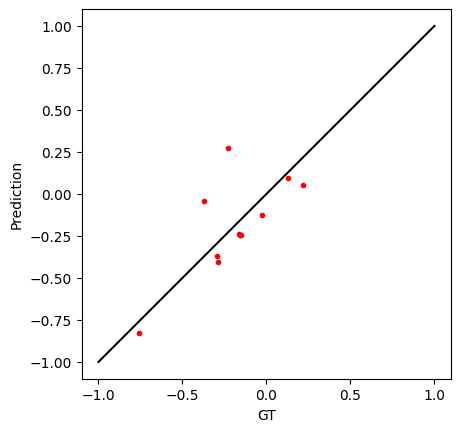

CC#CC(=O)NCC CCNC(=O)C#CC
SMILES result= CC#CC(=O)NCC GT:  CCNC(=O)C#CC  is novel:  True


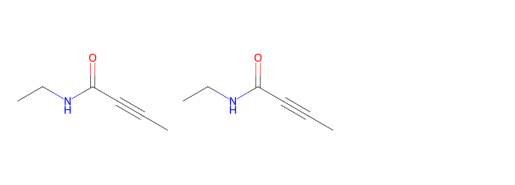

Properties:  [[-0.9975174  -0.18525173  0.38267034  0.04635372 -0.35042423 -0.30299076
  -0.05768453  0.24413249  0.17919767  0.18053204  0.19095908  0.1811272 ]
 [-0.8204382  -0.27858928  0.05680235 -0.040483   -0.2274456  -0.31871653
  -0.33066547  0.1548319   0.21566455  0.202636    0.22128358  0.2265317 ]]  unscaled:  [[ 3.6688257e-02  8.3837372e+01 -2.0260254e-01  1.7790673e-02
   2.1866076e-01  1.1884956e+03  1.3750640e-01  3.1486189e+01
  -3.1712592e+02 -3.1667123e+02 -3.1315591e+02 -3.1650113e+02]
 [ 2.6536002e+00  7.4955841e+01 -2.5586566e-01  1.7910070e-03
   2.5540063e-01  1.1621097e+03  1.0229281e-01  2.9656998e+01
  -3.0483493e+02 -3.0922125e+02 -3.0293527e+02 -3.0119745e+02]]
R2 score=  0.8365987724679848


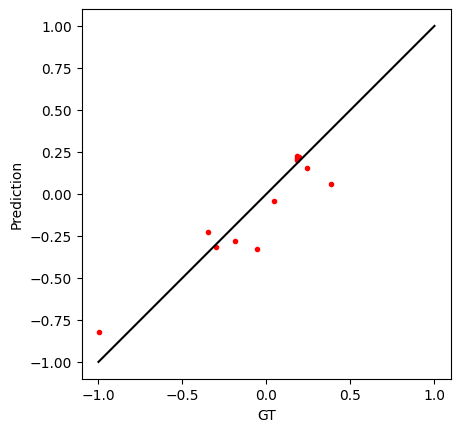

FC1=NNC(=N)C(=N)N1-)N NC1=COC(=O)OC1=N
SMILES result= FC1=NNC(=N)C(=N)N1-)N GT:  NC1=COC(=O)OC1=N  is novel:  True


[06:30:40] SMILES Parse Error: syntax error while parsing: FC1=NNC(=N)C(=N)N1-)N
[06:30:40] SMILES Parse Error: Failed parsing SMILES 'FC1=NNC(=N)C(=N)N1-)N' for input: 'FC1=NNC(=N)C(=N)N1-)N'


Properties:  [[-0.92737883 -0.4097627  -0.30581045 -0.3625373  -0.22618565 -0.43107945
  -0.5815923   0.07766744 -0.02069218 -0.03653304 -0.02712804 -0.02892647]
 [-0.57349956 -0.28013027  0.4708798  -0.27163213 -0.5811496  -0.30083966
  -0.2987409   0.07868388 -0.16959195 -0.18147561 -0.17463697 -0.176785  ]]  unscaled:  [[ 1.0732101e+00  6.2474030e+01 -3.1513470e-01 -5.7547495e-02
   2.5577703e-01  9.7357855e+02  6.9924131e-02  2.8076401e+01
  -3.8449768e+02 -3.8983127e+02 -3.8666046e+02 -3.8730005e+02]
 [ 6.3029089e+00  7.4809204e+01 -1.8818469e-01 -4.0798221e-02
   1.4973156e-01  1.1921049e+03  1.0641097e-01  2.8097219e+01
  -4.3468353e+02 -4.3868304e+02 -4.3637720e+02 -4.3713608e+02]]
R2 score=  -0.13000052140579488


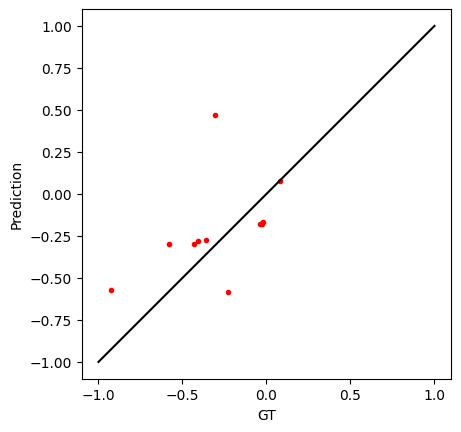

CC12CC3CC3C1(CO1)C23 CC12CC1CC1(O)CC21
SMILES result= CC12CC3CC3C1(CO1)C23 GT:  CC12CC1CC1(O)CC21  is novel:  True


[06:30:48] SMILES Parse Error: unclosed ring for input: 'CC12CC3CC3C1(CO1)C23'


Properties:  [[-0.7955159  -0.15033355  0.16247018 -0.30636787 -0.43441162 -0.20984738
   0.10535888  0.2899887  -0.01506845 -0.00962809 -0.01495671 -0.01337086]
 [-0.9296943  -0.14224997  0.32321337  0.0315435  -0.32285458 -0.38666543
   0.10544413  0.31644383  0.07348768  0.06541345  0.0766403   0.07914455]]  unscaled:  [[ 3.0219071e+00  8.7160011e+01 -2.3859426e-01 -4.7198281e-02
   1.9356953e-01  1.3447788e+03  1.5853843e-01  3.2425484e+01
  -3.8260223e+02 -3.8076318e+02 -3.8255820e+02 -3.8205707e+02]
 [ 1.0389918e+00  8.7929207e+01 -2.1232077e-01  1.5061891e-02
   2.2689719e-01  1.0480999e+03  1.5854943e-01  3.2967377e+01
  -3.5275485e+02 -3.5547101e+02 -3.5168616e+02 -3.5087454e+02]]
R2 score=  0.7529895104505879


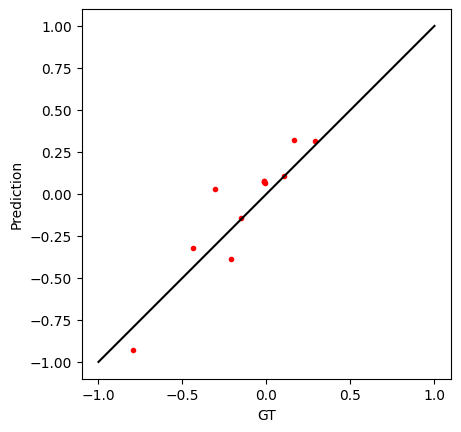

C1OCC2=CCCCC12 C1CC2CCC=CC2O1
SMILES result= C1OCC2=CCCCC12 GT:  C1CC2CCC=CC2O1  is novel:  False


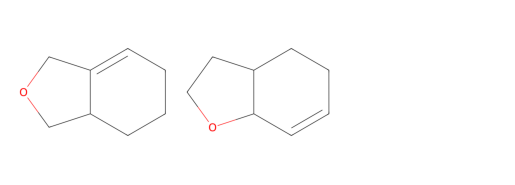

Properties:  [[-0.85379696 -0.05039645  0.18777227 -0.41902778 -0.5009922   0.02132695
  -0.05533757  0.16737354  0.00308776 -0.00090054  0.00105694  0.00160206]
 [-0.81414944 -0.09741413  0.28367373 -0.17027166 -0.4234466  -0.10449242
   0.05627464  0.271096    0.01624361  0.01555079  0.0156135   0.0113888 ]]  unscaled:  [[ 2.1606178e+00  9.6669533e+01 -2.3445861e-01 -6.7955866e-02
   1.7367859e-01  1.7326608e+03  1.3780914e-01  2.9913895e+01
  -3.7648279e+02 -3.7782162e+02 -3.7716092e+02 -3.7701041e+02]
 [ 2.7465367e+00  9.2195557e+01 -2.1878354e-01 -2.2122554e-02
   1.9684534e-01  1.5215514e+03  1.5220673e-01  3.2038494e+01
  -3.7204865e+02 -3.7227682e+02 -3.7225476e+02 -3.7371176e+02]]
R2 score=  0.8837286075551476


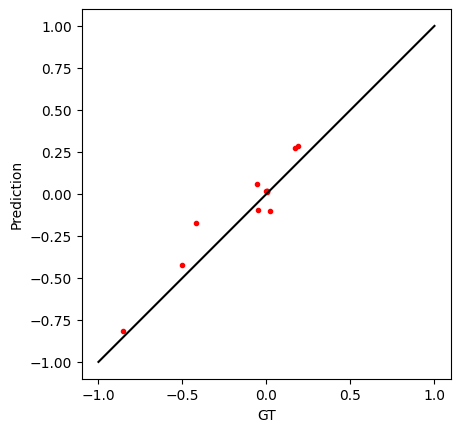

c1([nC(=O)nc(n1)O)N5 c1([nH]c(=O)nc(n1)O)N
SMILES result= c1([nC(=O)nc(n1)O)N5 GT:  c1([nH]c(=O)nc(n1)O)N  is novel:  True


[06:31:04] SMILES Parse Error: syntax error while parsing: c1([nC(=O)nc(n1)O)N5
[06:31:04] SMILES Parse Error: Failed parsing SMILES 'c1([nC(=O)nc(n1)O)N5' for input: 'c1([nC(=O)nc(n1)O)N5'


Properties:  [[-0.66026145 -0.41859505  0.2878847   0.09069839 -0.25692084 -0.3407535
  -0.37339142 -0.00796029 -0.2333274  -0.23348057 -0.24355513 -0.23588464]
 [-0.9577148  -0.46374267  0.32841256 -0.04626654 -0.35993114 -0.28314167
  -0.581347    0.18488751 -0.3959764  -0.40565512 -0.40245113 -0.40521342]]  unscaled:  [[ 5.0207243e+00  6.1633591e+01 -2.1809524e-01  2.5961179e-02
   2.4659489e-01  1.1251344e+03  9.6781313e-02  2.6322445e+01
  -4.5616522e+02 -4.5621088e+02 -4.5960550e+02 -4.5705569e+02]
 [ 6.2489921e-01  5.7337566e+01 -2.1147096e-01  7.2539051e-04
   2.1582057e-01  1.2217999e+03  6.9955774e-02  3.0272644e+01
  -5.1098520e+02 -5.1424097e+02 -5.1316010e+02 -5.1412823e+02]]
R2 score=  0.5317276152471935


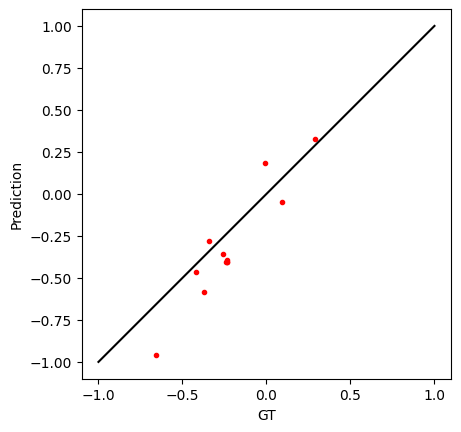

CCC1CC2(CN2)C1O CCC12CCC(O)C1N2
SMILES result= CCC1CC2(CN2)C1O GT:  CCC12CCC(O)C1N2  is novel:  False


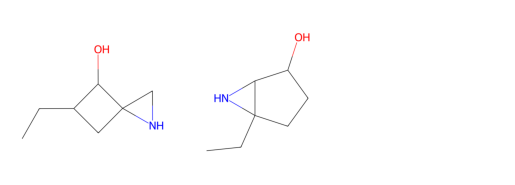

Properties:  [[-0.7547735  -0.17751847  0.20564048 -0.01665125 -0.28812024 -0.2871371
   0.1412904   0.4146902   0.01098385  0.00789805  0.01259246  0.01003971]
 [-0.76812756 -0.1255797   0.1776194  -0.13311374 -0.33707982 -0.22225326
   0.14339633  0.3318756   0.02057512  0.00938366  0.010905    0.01508973]]  unscaled:  [[ 3.6240063e+00  8.4573227e+01 -2.3153807e-01  6.1820070e-03
   2.3727407e-01  1.2150961e+03  1.6317347e-01  3.4979809e+01
  -3.7382147e+02 -3.7485611e+02 -3.7327298e+02 -3.7416644e+02]
 [ 3.4266572e+00  8.9515465e+01 -2.3611811e-01 -1.5276208e-02
   2.2264740e-01  1.3239631e+03  1.6344513e-01  3.3283474e+01
  -3.7058875e+02 -3.7435541e+02 -3.7384174e+02 -3.7246436e+02]]
R2 score=  0.9678410703167856


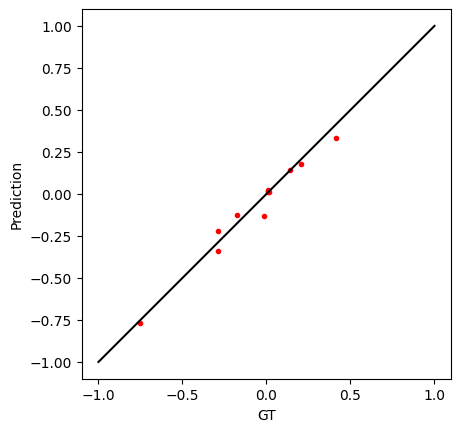

NC1(CNC(=O)C1)C#C OC1(CC2(CN2)C1)C#N
SMILES result= NC1(CNC(=O)C1)C#C GT:  OC1(CC2(CN2)C1)C#N  is novel:  True


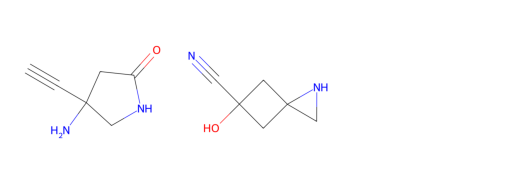

Properties:  [[-0.8377978  -0.25769198  0.27987558  0.01016887 -0.2946645  -0.4514265
   0.00167943  0.0684303  -0.04986104 -0.04676373 -0.04570862 -0.04763217]
 [-0.8448444  -0.3059597   0.3303555  -0.2512676  -0.4837852  -0.42595088
  -0.16251586  0.09963038 -0.12395301 -0.12749717 -0.12694652 -0.12291493]]  unscaled:  [[ 2.39705634e+00  7.69443207e+01 -2.19404340e-01  1.11236135e-02
   2.35318989e-01  9.39438721e+02  1.45164132e-01  2.78871918e+01
  -3.94328857e+02 -3.93279419e+02 -3.92922882e+02 -3.93604858e+02]
 [ 2.29292059e+00  7.23514023e+01 -2.11153403e-01 -3.70460562e-02
   1.78819165e-01  9.82183655e+02  1.23983525e-01  2.85262775e+01
  -4.19301178e+02 -4.20490021e+02 -4.20303467e+02 -4.18979065e+02]]
R2 score=  0.8236911698229095


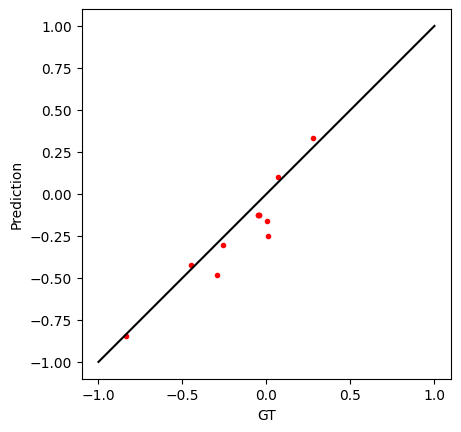

CC#CC(=NO)C#C CC#CC(=NO)C#C
SMILES result= CC#CC(=NO)C#C GT:  CC#CC(=NO)C#C  is novel:  False


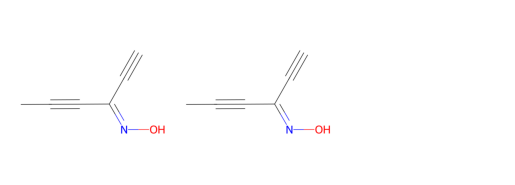

Properties:  [[-9.39574182e-01 -1.63766876e-01  2.76290596e-01  1.78585783e-01
  -2.26594687e-01 -4.81463186e-02 -7.20521584e-02  2.88363576e-01
   2.79031582e-02  1.71300136e-02  2.21447125e-02  2.24286113e-02]
 [-9.26182926e-01 -1.74272910e-01  3.85125279e-01  1.47724882e-01
  -2.72076458e-01 -1.71986207e-01 -1.16116405e-01  3.34437132e-01
  -2.09625985e-04 -4.93384013e-03 -2.39100843e-03 -3.48299323e-03]]  unscaled:  [[ 8.9298481e-01  8.5881767e+01 -2.1999031e-01  4.2154431e-02
   2.5565484e-01  1.6160931e+03  1.3565302e-01  3.2392197e+01
  -3.6811890e+02 -3.7174457e+02 -3.7005347e+02 -3.6999078e+02]
 [ 1.0908835e+00  8.4882065e+01 -2.0220126e-01  3.6468308e-02
   2.4206716e-01  1.4083051e+03  1.2996888e-01  3.3335941e+01
  -3.7759415e+02 -3.7918103e+02 -3.7832306e+02 -3.7872430e+02]]
R2 score=  0.967166865577198


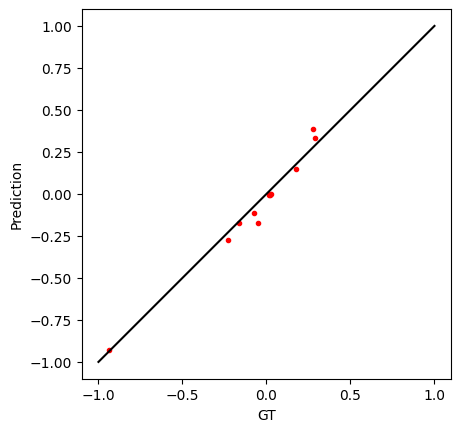

CC(O)(C#C)C#CC CC(CO)(C#C)C#C
SMILES result= CC(O)(C#C)C#CC GT:  CC(CO)(C#C)C#C  is novel:  True


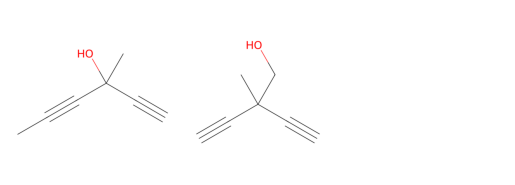

Properties:  [[-0.9148342  -0.22696798  0.24178082  0.27839512 -0.11472028 -0.37161854
   0.14318499  0.2591241   0.16283686  0.154258    0.16049264  0.16615783]
 [-0.93075156 -0.20017293  0.38558424  0.3093523  -0.18284541 -0.40675265
   0.21968353  0.3016345   0.17419684  0.17535198  0.18041003  0.150949  ]]  unscaled:  [[ 1.25859725e+00  7.98678589e+01 -2.25630924e-01  6.05443008e-02
   2.89077312e-01  1.07334668e+03  1.63417861e-01  3.17932701e+01
  -3.22640198e+02 -3.25526672e+02 -3.23424408e+02 -3.21546570e+02]
 [ 1.02336729e+00  8.24175491e+01 -2.02126250e-01  6.62481636e-02
   2.68724948e-01  1.01439594e+03  1.73285902e-01  3.26640320e+01
  -3.18811401e+02 -3.18417114e+02 -3.16711395e+02 -3.26672729e+02]]
R2 score=  0.9726738193141814


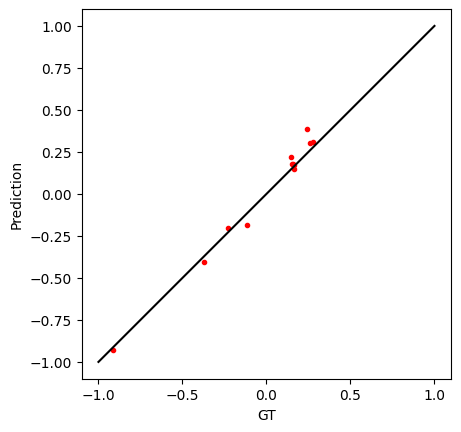

N=C1C=CN=CN==C1 N=C1C=NC=CN=C1
SMILES result= N=C1C=CN=CN==C1 GT:  N=C1C=NC=CN=C1  is novel:  True


[06:31:49] SMILES Parse Error: syntax error while parsing: N=C1C=CN=CN==C1
[06:31:49] SMILES Parse Error: Failed parsing SMILES 'N=C1C=CN=CN==C1' for input: 'N=C1C=CN=CN==C1'


Properties:  [[-7.6478279e-01 -1.8605998e-01 -6.1413523e-02 -2.8495097e-01
  -2.8598496e-01 -2.8709105e-01 -3.2616025e-01  6.7526929e-02
   2.3585730e-03  4.3658385e-04  2.4197184e-04 -2.9676594e-06]
 [-6.1877382e-01 -2.4179271e-01 -3.8300686e-02 -3.1413639e-01
  -3.3013973e-01 -3.8702533e-01 -3.1288999e-01 -6.3975722e-02
  -7.4501713e-03 -6.4648786e-03 -8.0489852e-03 -5.3357622e-03]]  unscaled:  [[ 3.4760871e+00  8.3760468e+01 -2.7518803e-01 -4.3252215e-02
   2.3791198e-01  1.2151733e+03  1.0287397e-01  2.7868689e+01
  -3.7672858e+02 -3.7737097e+02 -3.7743564e+02 -3.7755139e+02]
 [ 5.6338367e+00  7.8457214e+01 -2.7141026e-01 -4.8629627e-02
   2.2472075e-01  1.0474960e+03  1.0458579e-01  2.5175053e+01
  -3.8003452e+02 -3.7969702e+02 -3.8023001e+02 -3.7934879e+02]]
R2 score=  0.9080340122562601


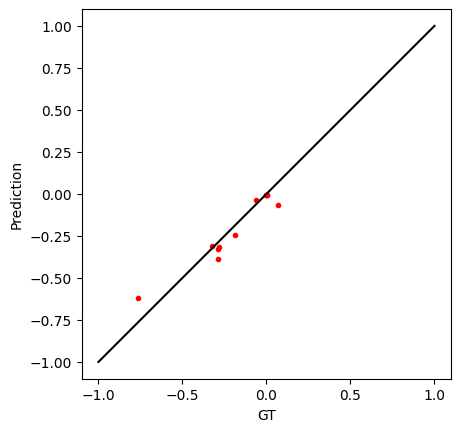

OCC1CCC=C1C#C3 OC1CCCC=C1C#C
SMILES result= OCC1CCC=C1C#C3 GT:  OC1CCCC=C1C#C  is novel:  True


[06:31:57] SMILES Parse Error: unclosed ring for input: 'OCC1CCC=C1C#C3'


Properties:  [[-9.8466307e-01 -1.9589950e-01  3.5445217e-02  3.7930760e-01
   6.6978842e-02 -4.0247908e-01  3.2318124e-01  2.5013348e-01
  -5.3705643e-03 -3.5158761e-03 -3.1090521e-03  1.4620228e-04]
 [-9.8020434e-01 -1.2350255e-01  1.7416213e-01  3.2762823e-01
  -3.2468550e-02 -3.0593637e-01  3.4636664e-01  4.3937987e-01
   6.6399187e-02  6.7667492e-02  6.8663009e-02  6.7494340e-02]]  unscaled:  [[ 2.2665223e-01  8.2824181e+01 -2.5935647e-01  7.9137422e-02
   3.4335992e-01  1.0215665e+03  1.8663675e-01  3.1609110e+01
  -3.7933359e+02 -3.7870309e+02 -3.7856503e+02 -3.7750107e+02]
 [ 2.9254416e-01  8.9713112e+01 -2.3668319e-01  6.9615498e-02
   3.1365001e-01  1.1835532e+03  1.8962759e-01  3.5485538e+01
  -3.5514401e+02 -3.5471133e+02 -3.5437482e+02 -3.5480127e+02]]
R2 score=  0.929809338824179


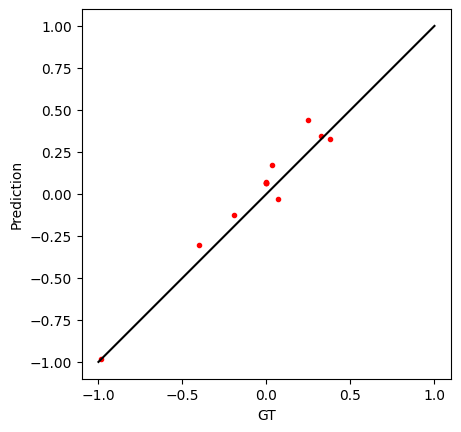

CN1CC2(CN2)C1=O CN1CC2(CN2)C1=O
SMILES result= CN1CC2(CN2)C1=O GT:  CN1CC2(CN2)C1=O  is novel:  False


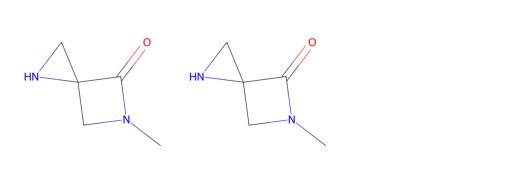

Properties:  [[-0.68118685 -0.14981088  0.1548785  -0.42327857 -0.5182751  -0.26481685
  -0.33026353  0.19458279 -0.02818355 -0.03702084 -0.03221054 -0.0398016 ]
 [-0.75304604 -0.18069054  0.1703869  -0.45964664 -0.55397534 -0.26092666
  -0.39471442  0.19139168 -0.04797537 -0.05462205 -0.05101739 -0.05092556]]  unscaled:  [[ 4.7114844e+00  8.7209747e+01 -2.3983510e-01 -6.8739079e-02
   1.6851532e-01  1.2525468e+03  1.0234466e-01  3.0471237e+01
  -3.8702261e+02 -3.8999567e+02 -3.8837347e+02 -3.9096558e+02]
 [ 3.6495352e+00  8.4271393e+01 -2.3730025e-01 -7.5439893e-02
   1.5784986e-01  1.2590740e+03  9.4030723e-02  3.0405872e+01
  -3.9369333e+02 -3.9592804e+02 -3.9471216e+02 -3.9471490e+02]]
R2 score=  0.9819490419992227


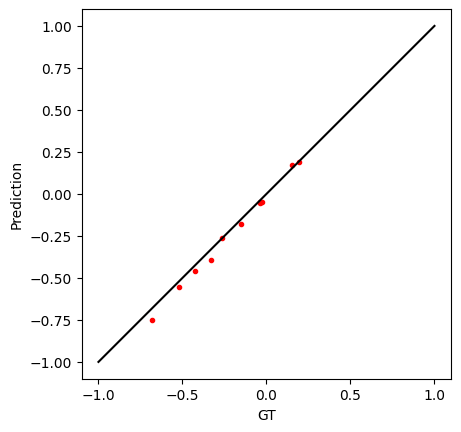

C1C(=O1CN)c(=Nn-3)C O=CC1OCC=C1C#N
SMILES result= C1C(=O1CN)c(=Nn-3)C GT:  O=CC1OCC=C1C#N  is novel:  True


[06:32:13] SMILES Parse Error: unclosed ring for input: 'C1C(=O1CN)c(=Nn-3)C'


Properties:  [[-0.52346003 -0.35144678 -0.080153   -0.24890523 -0.26140368 -0.39525992
  -0.39567843  0.00530983 -0.11104928 -0.11525273 -0.11163114 -0.11633538]
 [-0.8550779  -0.19652325  0.6489717  -0.0625343  -0.5326824  -0.24576512
  -0.1820901   0.23161514 -0.130594   -0.13135032 -0.1314244  -0.13492887]]  unscaled:  [[ 7.04240274e+00  6.80230865e+01 -2.78250992e-01 -3.66107859e-02
   2.45255649e-01  1.03367932e+03  9.39063653e-02  2.65942631e+01
  -4.14952057e+02 -4.16363129e+02 -4.15141541e+02 -4.16761414e+02]
 [ 2.14168739e+00  8.27648315e+01 -1.59075588e-01 -2.27194512e-03
   1.64211124e-01  1.28451318e+03  1.21458516e-01  3.12297897e+01
  -4.21539520e+02 -4.21788666e+02 -4.21812714e+02 -4.23028381e+02]]
R2 score=  -2.0973003126211975


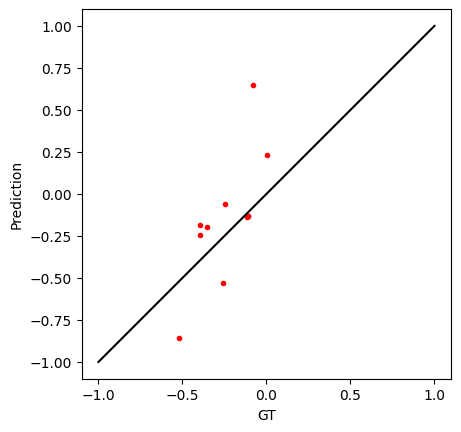

CC1CC(=O)OC1C CC1CC(C)C(=O)O1
SMILES result= CC1CC(=O)OC1C GT:  CC1CC(C)C(=O)O1  is novel:  False


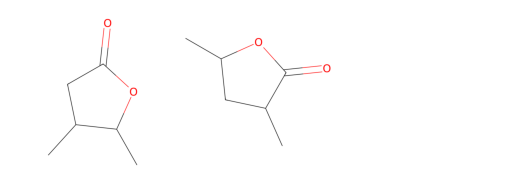

Properties:  [[-0.7325249  -0.2588377   0.15016684 -0.02908746 -0.2515264  -0.3569521
   0.02017519  0.28565273 -0.0728071  -0.07066983 -0.0688057  -0.0689008 ]
 [-0.659752   -0.3269527  -0.04892461  0.08066842 -0.08006492 -0.42835626
   0.00874436  0.19880337  0.06572095  0.05924442  0.05863125  0.0544871 ]]  unscaled:  [[ 3.9528010e+00  7.6835297e+01 -2.4060524e-01  3.8906352e-03
   2.4820648e-01  1.0979552e+03  1.4755003e-01  3.2336666e+01
  -4.0206274e+02 -4.0133679e+02 -4.0070755e+02 -4.0077353e+02]
 [ 5.0282526e+00  7.0353813e+01 -2.7314675e-01  2.4113158e-02
   2.9943061e-01  9.7814783e+02  1.4607549e-01  3.0557690e+01
  -3.5537262e+02 -3.5755026e+02 -3.5775598e+02 -3.5918539e+02]]
R2 score=  0.7694926923241621


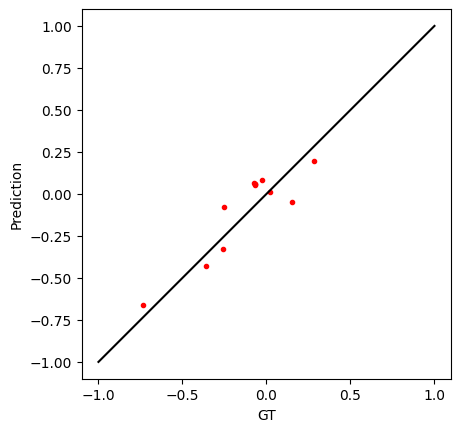

c1c([nH]c(n1)O)C2CC2 c1c(nc(o1)N)C2CC2
SMILES result= c1c([nH]c(n1)O)C2CC2 GT:  c1c(nc(o1)N)C2CC2  is novel:  False


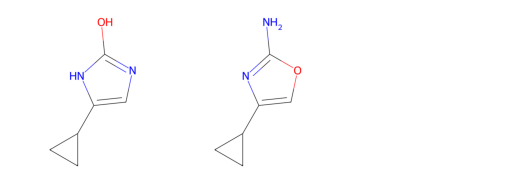

Properties:  [[-0.8187001  -0.17691307  0.2597897  -0.26862785 -0.4716952  -0.27553615
  -0.18798897  0.01481856 -0.05862002 -0.06070223 -0.06305172 -0.05999146]
 [-0.8365923  -0.4011312   0.03119682 -0.36536947 -0.4025921  -0.33815295
  -0.42975456 -0.07828892 -0.2618274  -0.2719841  -0.26458323 -0.2595711 ]]  unscaled:  [[ 2.6792865e+00  8.4630836e+01 -2.2268736e-01 -4.0244680e-02
   1.8243104e-01  1.2345610e+03  1.2069758e-01  2.6789036e+01
  -3.9728104e+02 -3.9797729e+02 -3.9876825e+02 -3.9777060e+02]
 [ 2.4148715e+00  6.3295357e+01 -2.6005086e-01 -5.8069322e-02
   2.0307560e-01  1.1294978e+03  8.9510672e-02  2.4881868e+01
  -4.6577100e+02 -4.6918820e+02 -4.6669281e+02 -4.6503928e+02]]
R2 score=  0.5561568475439815


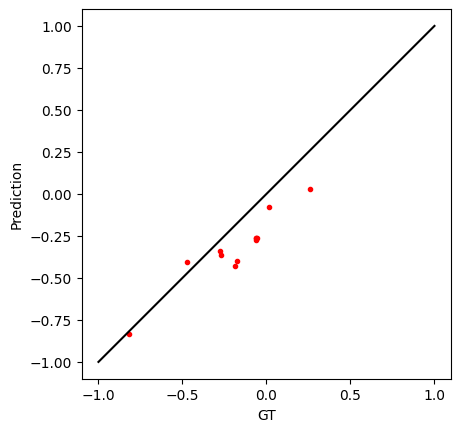

c1c[n@c2c1CC(=O)N2 c1c[nH]c2c1NC(=O)C2
SMILES result= c1c[n@c2c1CC(=O)N2 GT:  c1c[nH]c2c1NC(=O)C2  is novel:  True


[06:32:38] SMILES Parse Error: syntax error while parsing: c1c[n@c2c1CC(=O)N2
[06:32:38] SMILES Parse Error: Failed parsing SMILES 'c1c[n@c2c1CC(=O)N2' for input: 'c1c[n@c2c1CC(=O)N2'


Properties:  [[-0.5782363  -0.2900867   0.16097514 -0.41100496 -0.5110533  -0.33389753
  -0.51981026 -0.06074517 -0.17331506 -0.17113613 -0.17175221 -0.1696363 ]
 [-0.44255355 -0.19226049  0.21445915 -0.1838267  -0.38328958 -0.18193755
  -0.43616378  0.06836843 -0.07523163 -0.07098715 -0.0714092  -0.07325479]]  unscaled:  [[ 6.2329087e+00  7.3861801e+01 -2.3883861e-01 -6.6477664e-02
   1.7067282e-01  1.1366378e+03  7.7893801e-02  2.5241226e+01
  -4.3593839e+02 -4.3519818e+02 -4.3540488e+02 -4.3472656e+02]
 [ 8.2380552e+00  8.3170448e+01 -2.3009667e-01 -2.4620069e-02
   2.0884225e-01  1.3916080e+03  8.8683903e-02  2.7885925e+01
  -4.0287988e+02 -4.0144376e+02 -4.0158505e+02 -4.0224100e+02]]
R2 score=  0.6369133031204811


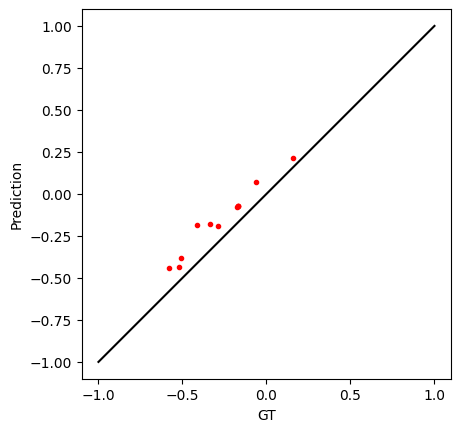

CN1C2CC=CC(O)C12 CC1C(O)C=CC2CN12
SMILES result= CN1C2CC=CC(O)C12 GT:  CC1C(O)C=CC2CN12  is novel:  False


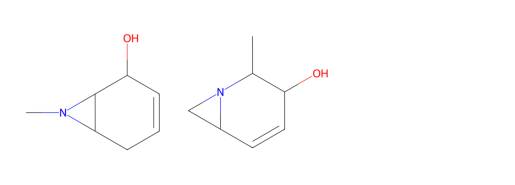

Properties:  [[-0.77492446 -0.1245774   0.12346187 -0.3682839  -0.44919476 -0.20012596
  -0.3252275   0.19093604  0.00161466 -0.00527007 -0.00127199 -0.00293702]
 [-0.7894298  -0.0909509   0.23897047 -0.41565657 -0.54748726 -0.13993332
  -0.33852005  0.23202635 -0.00846278 -0.01626975 -0.01248813 -0.01639241]]  unscaled:  [[ 3.3262115e+00  8.9610840e+01 -2.4497016e-01 -5.8606308e-02
   1.8915306e-01  1.3610901e+03  1.0299429e-01  3.0396540e+01
  -3.7697928e+02 -3.7929431e+02 -3.7794589e+02 -3.7854028e+02]
 [ 3.1118488e+00  9.2810562e+01 -2.2609028e-01 -6.7334719e-02
   1.5978818e-01  1.4620859e+03  1.0127960e-01  3.1238211e+01
  -3.8037585e+02 -3.8300168e+02 -3.8172617e+02 -3.8307544e+02]]
R2 score=  0.9611234787311087


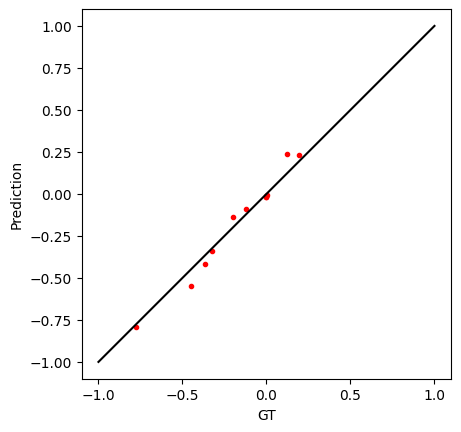

OC2C(O)CO3CC3O2 COC(=O)C(O)CC=O
SMILES result= OC2C(O)CO3CC3O2 GT:  COC(=O)C(O)CC=O  is novel:  True


[06:32:54] Explicit valence for atom # 5 O, 3, is greater than permitted


Properties:  [[-0.5958112  -0.3097771   0.02815806 -0.16026154 -0.28807983 -0.18385093
  -0.24106857  0.35927007 -0.12915581 -0.13354625 -0.13220188 -0.13405843]
 [-0.8214151  -0.4005305   0.18376836 -0.00976231 -0.2610973  -0.34672385
  -0.3196061   0.1783068  -0.25211775 -0.2523172  -0.25621846 -0.25208405]]  unscaled:  [[ 5.9731832e+00  7.1988159e+01 -2.6054755e-01 -2.0278189e-02
   2.3728615e-01  1.3883976e+03  1.1385050e-01  3.3844608e+01
  -4.2105475e+02 -4.2252881e+02 -4.2207474e+02 -4.2273499e+02]
 [ 2.6391630e+00  6.3352524e+01 -2.3511307e-01  7.4512945e-03
   2.4534719e-01  1.1151168e+03  1.0371943e-01  3.0137848e+01
  -4.6249841e+02 -4.6255960e+02 -4.6387357e+02 -4.6251575e+02]]
R2 score=  0.5759489647716238


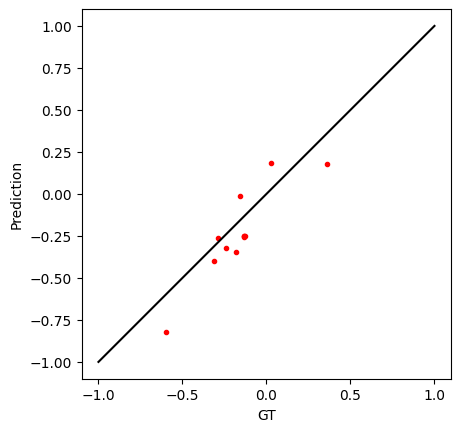

CN1CC1(C#C)C1CO21 CC1(CN1)C1OC1C#C
SMILES result= CN1CC1(C#C)C1CO21 GT:  CC1(CN1)C1OC1C#C  is novel:  True


[06:33:02] SMILES Parse Error: unclosed ring for input: 'CN1CC1(C#C)C1CO21'


Properties:  [[-0.8303889  -0.28686568  0.11247995  0.32058144 -0.02281059 -0.39166355
   0.02579783  0.20585752 -0.14480333 -0.11315114 -0.12368724 -0.12973633]
 [-0.86753494 -0.20623186  0.18517491  0.24534346 -0.10050099 -0.41308576
   0.16909027  0.18047804 -0.04700177 -0.04012321 -0.03654337 -0.03288557]]  unscaled:  [[ 2.5065467e+00  7.4168297e+01 -2.4676515e-01  6.8317130e-02
   3.1653535e-01  1.0397136e+03  1.4827533e-01  3.0702183e+01
  -4.2632867e+02 -4.1565479e+02 -4.1920496e+02 -4.2127823e+02]
 [ 1.9575952e+00  8.1841011e+01 -2.3488317e-01  5.4454532e-02
   2.9332533e-01  1.0037698e+03  1.6675955e-01  3.0182323e+01
  -3.9336517e+02 -3.9104132e+02 -3.8983380e+02 -3.8863452e+02]]
R2 score=  0.9209809248676004


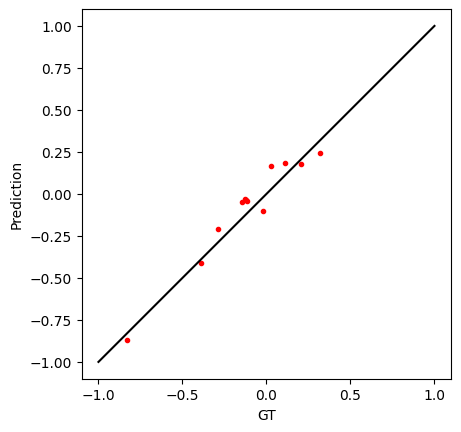

CCN1CC1CC(Cc)=OH4 CCCC(=O)C1CN1C
SMILES result= CCN1CC1CC(Cc)=OH4 GT:  CCCC(=O)C1CN1C  is novel:  True


[06:33:10] SMILES Parse Error: syntax error while parsing: CCN1CC1CC(Cc)=OH4
[06:33:10] SMILES Parse Error: Failed parsing SMILES 'CCN1CC1CC(Cc)=OH4' for input: 'CCN1CC1CC(Cc)=OH4'


Properties:  [[-0.85991377 -0.12863769  0.11512866 -0.0221894  -0.23966447 -0.01630418
   0.04722407  0.48556754  0.01769153  0.01577676  0.01457235  0.01558506]
 [-0.80402154 -0.23917405  0.27179307  0.09414174 -0.25354168 -0.3333843
   0.02651608  0.17988227 -0.04877095 -0.05529343 -0.05061723 -0.05270122]]  unscaled:  [[ 2.0702224e+00  8.9224480e+01 -2.4633221e-01  5.1616034e-03
   2.5175023e-01  1.6695204e+03  1.5103923e-01  3.6431622e+01
  -3.7156064e+02 -3.7220068e+02 -3.7260568e+02 -3.7229739e+02]
 [ 2.8962090e+00  7.8706390e+01 -2.2072543e-01  2.6595615e-02
   2.4760441e-01  1.1374990e+03  1.4836797e-01  3.0170118e+01
  -3.9396149e+02 -3.9615433e+02 -3.9457733e+02 -3.9531342e+02]]
R2 score=  0.7440363157803584


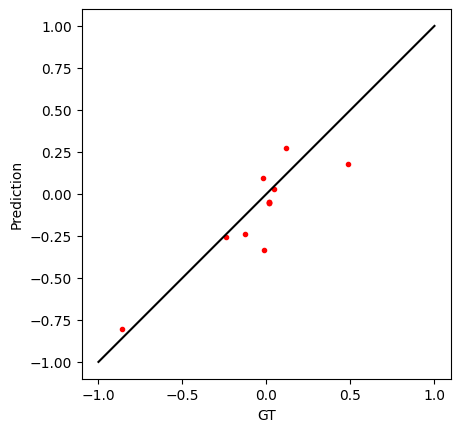

CCC1(CCC1C)C=O CC(C)(C=O)C1CCC1
SMILES result= CCC1(CCC1C)C=O GT:  CC(C)(C=O)C1CCC1  is novel:  False


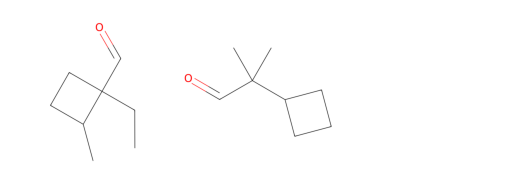

Properties:  [[-0.87929916 -0.14565799  0.12512098  0.16306381 -0.11552612 -0.21087545
   0.29785115  0.4728237   0.04545059  0.04690727  0.04828763  0.04650403]
 [-0.9976955  -0.13584362  0.21834226  0.16628416 -0.18889774 -0.29284027
   0.26049438  0.47498217  0.05382494  0.0505004   0.05505119  0.05618132]]  unscaled:  [[ 1.7837411e+00  8.7604919e+01 -2.4469897e-01  3.9294507e-02
   2.8883657e-01  1.3430537e+03  1.8336926e-01  3.6170586e+01
  -3.6220465e+02 -3.6170837e+02 -3.6124219e+02 -3.6187613e+02]
 [ 3.4056280e-02  8.8538795e+01 -2.2946197e-01  3.9887857e-02
   2.6691681e-01  1.2055269e+03  1.7855038e-01  3.6214798e+01
  -3.5938208e+02 -3.6049734e+02 -3.5896262e+02 -3.5861438e+02]]
R2 score=  0.9699158893960508


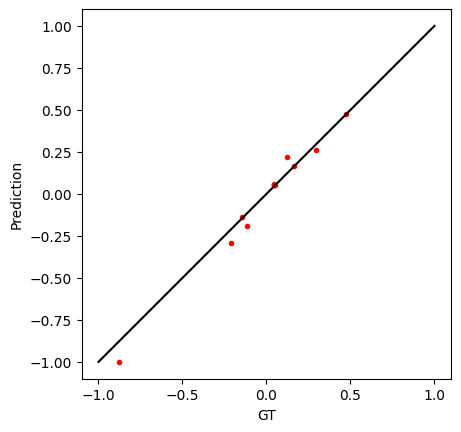

CC1C2CC(C#N)C12C CC1(C)CC2C(C#N)C12
SMILES result= CC1C2CC(C#N)C12C GT:  CC1(C)CC2C(C#N)C12  is novel:  False


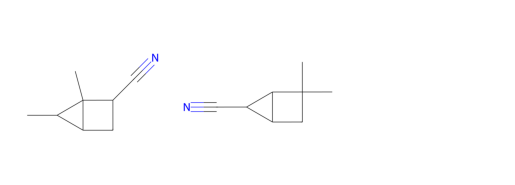

Properties:  [[-0.93075943 -0.19038332  0.2679727  -0.03518154 -0.32686353 -0.41217104
   0.13806023  0.23909959  0.01712076  0.02079403  0.01880154  0.02449263]
 [-0.85682744 -0.13775462  0.34986952 -0.07968968 -0.3956966  -0.37006718
   0.15300414  0.24883828  0.03569737  0.02971881  0.03145614  0.03873765]]  unscaled:  [[ 1.0232509e+00  8.3349075e+01 -2.2134985e-01  2.7678011e-03
   2.2569953e-01  1.0053046e+03  1.6275679e-01  3.1383097e+01
  -3.7175302e+02 -3.7050964e+02 -3.7118027e+02 -3.6929510e+02]
 [ 2.1158328e+00  8.8356956e+01 -2.0796382e-01 -5.4328237e-03
   2.0513563e-01  1.0759496e+03  1.6468450e-01  3.1582579e+01
  -3.6549191e+02 -3.6750159e+02 -3.6691510e+02 -3.6449377e+02]]
R2 score=  0.9798245855140071


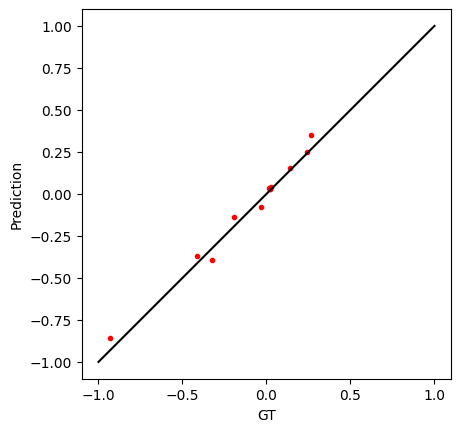

CCn1cnnn1 CCn1cnnn1
SMILES result= CCn1cnnn1 GT:  CCn1cnnn1  is novel:  False


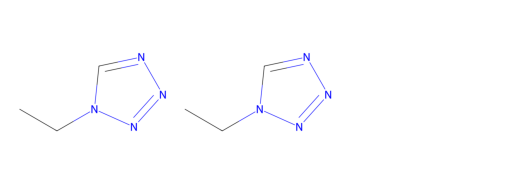

Properties:  [[-0.7825975  -0.61524564 -0.6749465  -0.1464873   0.0963759  -0.67685825
  -0.5283799  -0.43176416  0.12858042  0.13188332  0.12626836  0.10921566]
 [-0.9748423  -0.6306864  -0.5478679  -0.10100486  0.04450513 -0.6395237
  -0.4694787  -0.39408535  0.157539    0.1512886   0.13914122  0.13534786]]  unscaled:  [[ 3.2128179e+00  4.2921299e+01 -3.7547001e-01 -1.7740285e-02
   3.5214230e-01  5.6119214e+02  7.6788343e-02  1.7641459e+01
  -3.3418616e+02 -3.3306787e+02 -3.3495941e+02 -3.4073901e+02]
 [ 3.7178537e-01  4.1452034e+01 -3.5469902e-01 -9.3601458e-03
   3.3664590e-01  6.2383496e+02  8.4386393e-02  1.8413252e+01
  -3.2442584e+02 -3.2652750e+02 -3.3062073e+02 -3.3193112e+02]]
R2 score=  0.9578097882722347


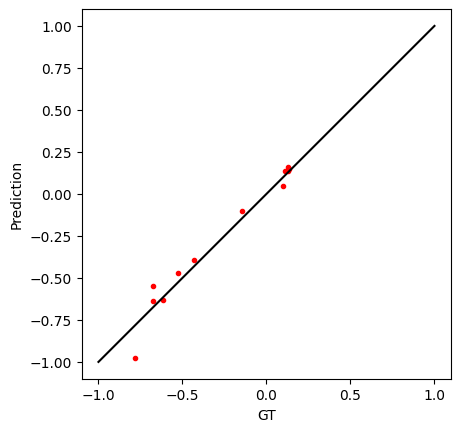

C1OC1C1CC2COC12 C1C2CC3(COC3)OC12
SMILES result= C1OC1C1CC2COC12 GT:  C1C2CC3(COC3)OC12  is novel:  False


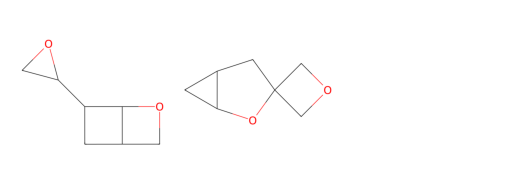

Properties:  [[-0.9350212  -0.33234942  0.22018684  0.07806683 -0.23685576 -0.49161002
  -0.15192106 -0.08124764  0.06155212  0.05960114  0.05626886  0.0594764 ]
 [-0.84431094 -0.2581921   0.14056447 -0.26248243 -0.40376392 -0.3479582
   0.02877111  0.1912167  -0.09008323 -0.08616008 -0.08710156 -0.0842731 ]]  unscaled:  [[ 9.6026939e-01  6.9840294e+01 -2.2916046e-01  2.3633813e-02
   2.5258934e-01  8.7201581e+02  1.2535021e-01  2.4821264e+01
  -3.5677768e+02 -3.5742999e+02 -3.5855219e+02 -3.5750375e+02]
 [ 2.3008041e+00  7.6896736e+01 -2.4217473e-01 -3.9112389e-02
   2.0272551e-01  1.1130458e+03  1.4865887e-01  3.0402287e+01
  -4.0788556e+02 -4.0655768e+02 -4.0687405e+02 -4.0595477e+02]]
R2 score=  0.6698981367649696


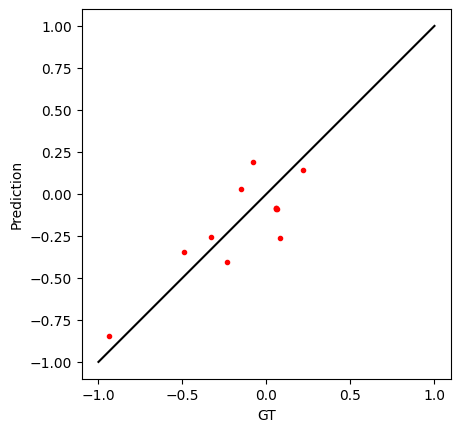

OCC1(OC1C)C=O CC1(O)COC1C=O
SMILES result= OCC1(OC1C)C=O GT:  CC1(O)COC1C=O  is novel:  True


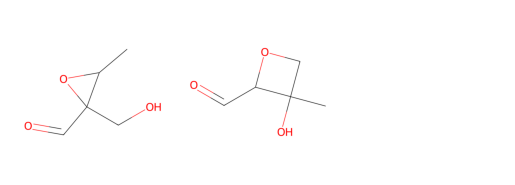

Properties:  [[-0.9156597  -0.28978547  0.13350438  0.09354452 -0.16929965 -0.37119073
  -0.05510941  0.24110965  0.03726628  0.03060412  0.03783483  0.03296286]
 [-0.93200636 -0.38483423  0.22603196 -0.01436514 -0.30929878 -0.444067
  -0.25164133  0.09113432 -0.05362772 -0.05115719 -0.04982929 -0.05230841]]  unscaled:  [[ 1.2463975e+00  7.3890465e+01 -2.4332871e-01  2.6485577e-02
   2.7277172e-01  1.0740645e+03  1.3783857e-01  3.1424271e+01
  -3.6496310e+02 -3.6720325e+02 -3.6476523e+02 -3.6644016e+02]
 [ 1.0048236e+00  6.4846100e+01 -2.2820508e-01  6.6032228e-03
   2.3094699e-01  9.5178705e+02  1.1248665e-01  2.8352249e+01
  -3.9559845e+02 -3.9476025e+02 -3.9431174e+02 -3.9518100e+02]]
R2 score=  0.8631292022533572


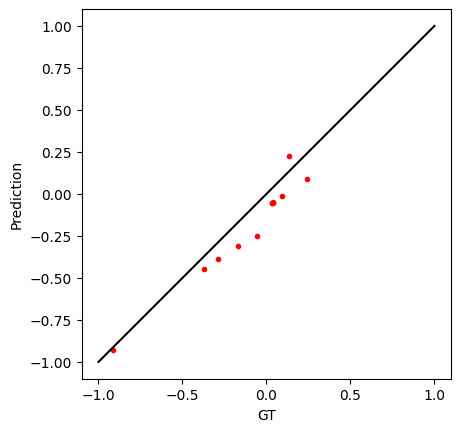

NC1=CC(=O)C2(CO2)C1 NC1=C(C=O)C2OC2C1
SMILES result= NC1=CC(=O)C2(CO2)C1 GT:  NC1=C(C=O)C2OC2C1  is novel:  False


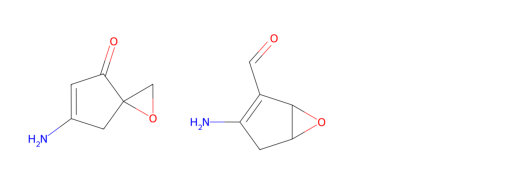

Properties:  [[-0.83704895 -0.10291921  0.24088246 -0.12869374 -0.3739975  -0.21686156
  -0.3632229   0.34400266  0.03110715  0.02528855  0.02159207  0.02081193]
 [-0.7422448  -0.25221238  0.30770943 -0.12886427 -0.4040362  -0.35880464
  -0.32947427  0.26025257 -0.06200839 -0.06359485 -0.06025752 -0.0663043 ]]  unscaled:  [[ 2.40812325e+00  9.16717224e+01 -2.25777760e-01 -1.44618228e-02
   2.11618245e-01  1.33300977e+03  9.80930179e-02  3.35318794e+01
  -3.67039001e+02 -3.68994781e+02 -3.70239716e+02 -3.70535675e+02]
 [ 3.80915809e+00  7.74657364e+01 -2.14854911e-01 -1.44932428e-02
   2.02644184e-01  1.09484680e+03  1.02446474e-01  3.18163834e+01
  -3.98423096e+02 -3.98952240e+02 -3.97826477e+02 -3.99898376e+02]]
R2 score=  0.9109691783775646


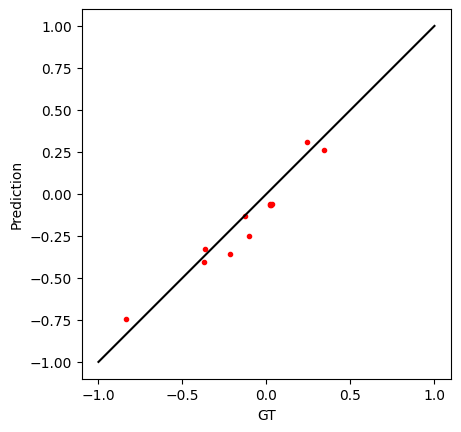

Cc1c(cnn1C)C#C Cc1c(cnn1C)C#C
SMILES result= Cc1c(cnn1C)C#C GT:  Cc1c(cnn1C)C#C  is novel:  False


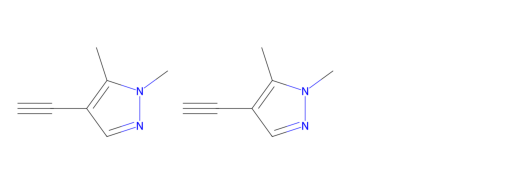

Properties:  [[-0.7085466  -0.3009806  -0.04103552 -0.09711401 -0.20225668 -0.33521053
  -0.28040335  0.178618   -0.08241417 -0.08591853 -0.08273534 -0.08468799]
 [-0.79468083 -0.32866684 -0.18658885 -0.17947066 -0.16989854 -0.3374063
  -0.37822083  0.17228657 -0.12557873 -0.13199091 -0.12690362 -0.12902068]]  unscaled:  [[ 4.3071570e+00  7.2825195e+01 -2.7185726e-01 -8.6432565e-03
   2.6292580e-01  1.1344348e+03  1.0877645e-01  3.0144222e+01
  -4.0530075e+02 -4.0647629e+02 -4.0540247e+02 -4.0609460e+02]
 [ 3.0342476e+00  7.0190712e+01 -2.9564795e-01 -2.3817468e-02
   2.7259281e-01  1.1307506e+03  9.6158333e-02  3.0014532e+01
  -4.1984915e+02 -4.2200461e+02 -4.2028900e+02 -4.2103702e+02]]
R2 score=  0.894827987688714


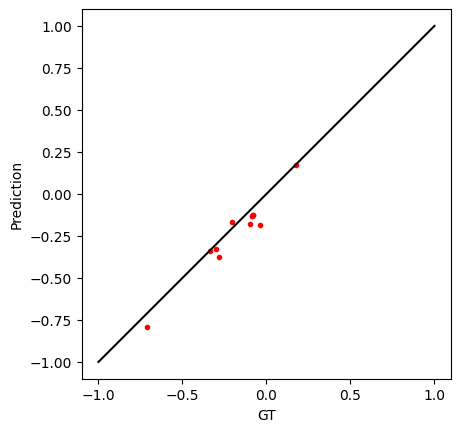

N=CN1CC=CC1=O N=C1C=CCN1C=O
SMILES result= N=CN1CC=CC1=O GT:  N=C1C=CCN1C=O  is novel:  False


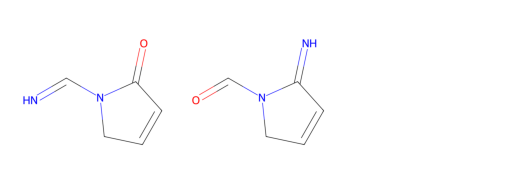

Properties:  [[-0.7724389  -0.2829382   0.12560366 -0.15099369 -0.32889968 -0.45650348
  -0.5600591   0.04854682  0.13560021  0.12594412  0.12772945  0.13453868]
 [-0.75555825 -0.2760275  -0.03242072 -0.2261988  -0.2760151  -0.44398993
  -0.50333047 -0.05245482  0.12943867  0.1423548   0.1490248   0.14107934]]  unscaled:  [[ 3.3629436e+00  7.4542015e+01 -2.4462007e-01 -1.8570587e-02
   2.2509122e-01  9.3092023e+02  7.2701842e-02  2.7479908e+01
  -3.3182019e+02 -3.3506964e+02 -3.3446695e+02 -3.3220386e+02]
 [ 3.6124091e+00  7.5199600e+01 -2.7044916e-01 -3.2427128e-02
   2.4089049e-01  9.5191638e+02  8.0019638e-02  2.5411041e+01
  -3.3389688e+02 -3.2953857e+02 -3.2728955e+02 -3.2999933e+02]]
R2 score=  0.9574067549000315


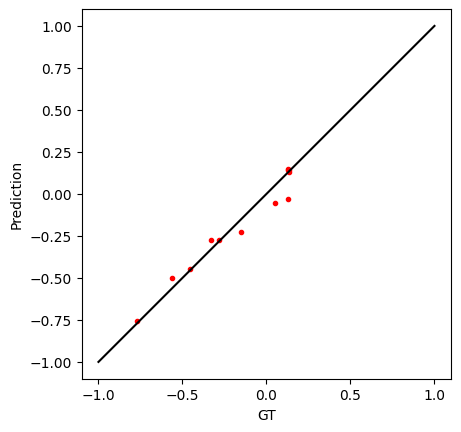

C1CC11C2NC11C2OC1 C1NC11C2CC1C21CO1
SMILES result= C1CC11C2NC11C2OC1 GT:  C1NC11C2CC1C21CO1  is novel:  True


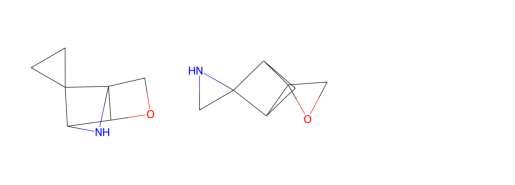

Properties:  [[-0.8466011  -0.15517719  0.1944536  -0.23084874 -0.39876533 -0.33309054
  -0.12304556  0.14814962  0.00754899  0.01095181  0.00920812  0.00607532]
 [-0.8819534  -0.20078261  0.14221828 -0.02994478 -0.2600029  -0.24378417
   0.05762     0.24069983 -0.01984207 -0.02081016 -0.02047293 -0.02380956]]  unscaled:  [[ 2.2669592e+00  8.6699112e+01 -2.3336655e-01 -3.3283882e-02
   2.0421886e-01  1.1379918e+03  1.2907505e-01  2.9520123e+01
  -3.7497913e+02 -3.7382690e+02 -3.7441364e+02 -3.7550266e+02]
 [ 1.7445160e+00  8.2359528e+01 -2.4190442e-01  3.7326738e-03
   2.4567413e-01  1.2878370e+03  1.5238029e-01  3.1415876e+01
  -3.8421115e+02 -3.8453201e+02 -3.8441742e+02 -3.8557544e+02]]
R2 score=  0.8677601251351267


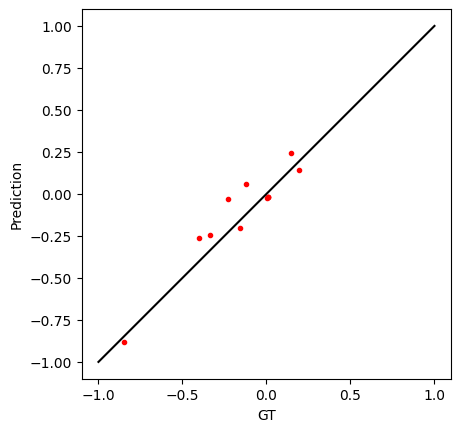

CC12CC(=O)C3CC1C23 CC1C2C3CC3C1C2=O
SMILES result= CC12CC(=O)C3CC1C23 GT:  CC1C2C3CC3C1C2=O  is novel:  False


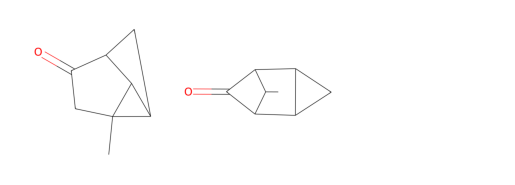

Properties:  [[-0.8686112  -0.18122402  0.10026385  0.17500684 -0.09592421 -0.35182524
   0.21382742  0.29148704  0.05745944  0.05869254  0.06083962  0.06056564]
 [-0.93211955 -0.14868356  0.2539498   0.23477957 -0.15382934 -0.34935695
   0.16567445  0.22800677  0.09246875  0.0855276   0.08830607  0.09215211]]  unscaled:  [[ 1.9416897e+00  8.4220627e+01 -2.4876188e-01  4.1495010e-02
   2.9469264e-01  1.1065574e+03  1.7253049e-01  3.2456177e+01
  -3.5815710e+02 -3.5773624e+02 -3.5701166e+02 -3.5713660e+02]
 [ 1.0031509e+00  8.7317017e+01 -2.2364190e-01  5.2508134e-02
   2.7739349e-01  1.1106989e+03  1.6631892e-01  3.1155878e+01
  -3.4635742e+02 -3.4869168e+02 -3.4775430e+02 -3.4649036e+02]]
R2 score=  0.9579530819347788


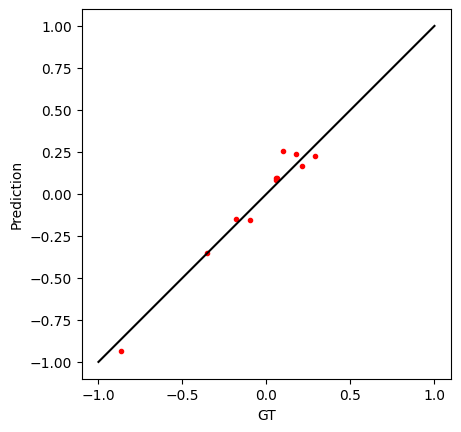

CCC(C)(C)NC=N CCC(C)C1(O)CC1
SMILES result= CCC(C)(C)NC=N GT:  CCC(C)C1(O)CC1  is novel:  True


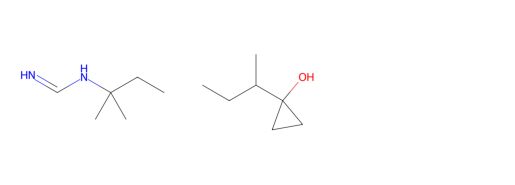

Properties:  [[-0.93876237 -0.22562544  0.3024607   0.38385883 -0.09278221 -0.38872826
   0.34050706  0.3057287   0.13087349  0.13174611  0.13439634  0.13075587]
 [-0.67395645 -0.16998357  0.1745384  -0.12926815 -0.34063274 -0.06300644
   0.09110043  0.36739683 -0.02989451 -0.02552401 -0.02285467 -0.02828032]]  unscaled:  [[ 9.0498197e-01  7.9995605e+01 -2.1571280e-01  7.9975992e-02
   2.9563132e-01  1.0446387e+03  1.8887173e-01  3.2747894e+01
  -3.3341330e+02 -3.3311414e+02 -3.3221994e+02 -3.3347888e+02]
 [ 4.8183370e+00  8.5290215e+01 -2.3662169e-01 -1.4567658e-02
   2.2158597e-01  1.5911597e+03  1.5669914e-01  3.4011074e+01
  -3.8759927e+02 -3.8612079e+02 -3.8522012e+02 -3.8708228e+02]]
R2 score=  0.5722095054844815


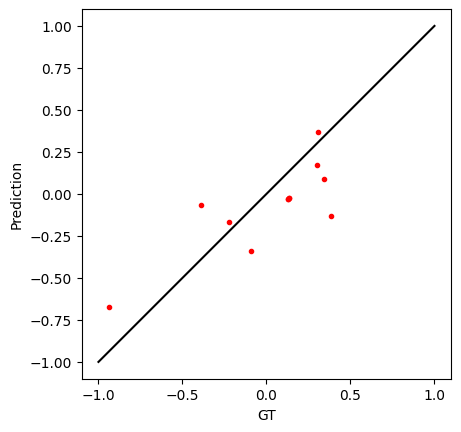

CCn1c(c(nn1)O)C CNc1c(n(nn1)C)N
SMILES result= CCn1c(c(nn1)O)C GT:  CNc1c(n(nn1)C)N  is novel:  False


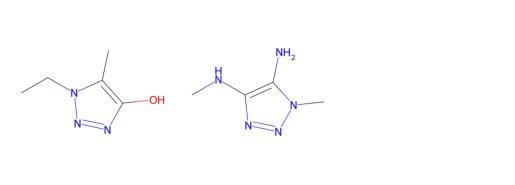

Properties:  [[-0.6152439  -0.324433    0.0248673  -0.2990158  -0.36207008 -0.3463784
  -0.4685291  -0.00221798 -0.01638911 -0.00555882 -0.00955145 -0.00832456]
 [-0.8441063  -0.27371994  0.13753068  0.02663569 -0.20971991 -0.2628151
  -0.00827583  0.3061917  -0.18442416 -0.18531191 -0.18357325 -0.18148597]]  unscaled:  [[ 5.6860023e+00  7.0593582e+01 -2.6108542e-01 -4.5843657e-02
   2.1518156e-01  1.1156965e+03  8.4508888e-02  2.6440067e+01
  -3.8304736e+02 -3.7939166e+02 -3.8073642e+02 -3.8035617e+02]
 [ 2.3038280e+00  7.5419182e+01 -2.4267061e-01  1.4157626e-02
   2.6069617e-01  1.2559054e+03  1.4387995e-01  3.2757378e+01
  -4.3968268e+02 -4.3997601e+02 -4.3938904e+02 -4.3872052e+02]]
R2 score=  -0.1450405305380995


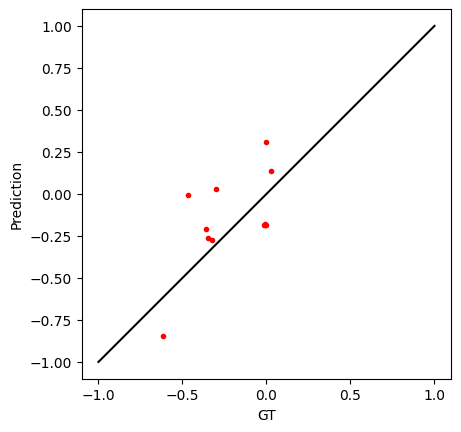

O=C1CC2C3(COC23)N1 C1C2OC2C11COC=N1
SMILES result= O=C1CC2C3(COC23)N1 GT:  C1C2OC2C11COC=N1  is novel:  True


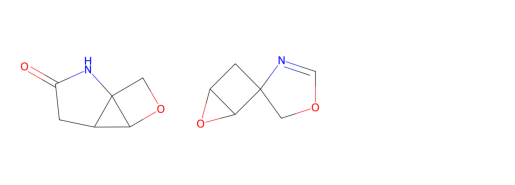

Properties:  [[-0.6992672  -0.22518994  0.12262572 -0.44444945 -0.49870354 -0.29584143
  -0.25243628  0.08646897 -0.06873457 -0.06811883 -0.06952871 -0.06967103]
 [-0.91332936 -0.33857235  0.10486083 -0.04331775 -0.26209015 -0.45572647
  -0.2774679  -0.06235099 -0.08780047 -0.09155446 -0.0888352  -0.08627089]]  unscaled:  [[ 4.4442892e+00  8.0037048e+01 -2.4510682e-01 -7.2639808e-02
   1.7436232e-01  1.2004913e+03  1.1238410e-01  2.8256685e+01
  -4.0069009e+02 -4.0047702e+02 -4.0095123e+02 -4.0103311e+02]
 [ 1.2808360e+00  6.9248146e+01 -2.4801050e-01  1.2687052e-03
   2.4505056e-01  9.3222394e+02  1.0915511e-01  2.5208334e+01
  -4.0711618e+02 -4.0837579e+02 -4.0745834e+02 -4.0662811e+02]]
R2 score=  0.5101192607155149


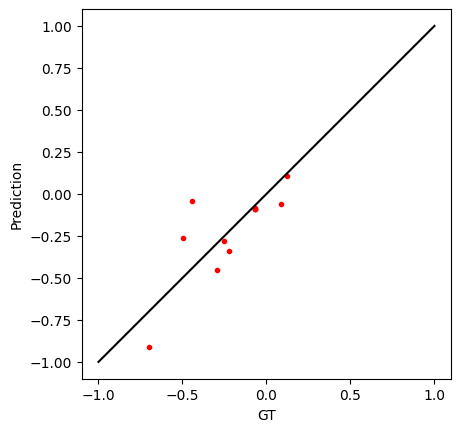

CC1(CO)CC1C#C CC1C(O)CC1C#C
SMILES result= CC1(CO)CC1C#C GT:  CC1C(O)CC1C#C  is novel:  False


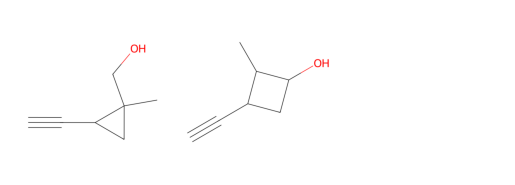

Properties:  [[-0.9285974  -0.20217478  0.20720625  0.21740384 -0.1313022  -0.32066578
   0.2113115   0.43105844  0.16737667  0.15141399  0.15340038  0.14942835]
 [-0.9858496  -0.20883928  0.24217926  0.26715678 -0.12793985 -0.38152966
   0.11465825  0.34509897  0.12408564  0.10989787  0.12067467  0.11127367]]  unscaled:  [[ 1.0552020e+00  8.2227058e+01 -2.3128213e-01  4.9306657e-02
   2.8412348e-01  1.1588391e+03  1.7220595e-01  3.5315086e+01
  -3.2111011e+02 -3.2648523e+02 -3.2581479e+02 -3.2718527e+02]
 [ 2.0911716e-01  8.1592896e+01 -2.2556579e-01  5.8473639e-02
   2.8512797e-01  1.0567170e+03  1.5973800e-01  3.3554333e+01
  -3.3570111e+02 -3.4047791e+02 -3.3684473e+02 -3.4004541e+02]]
R2 score=  0.9766685910787796


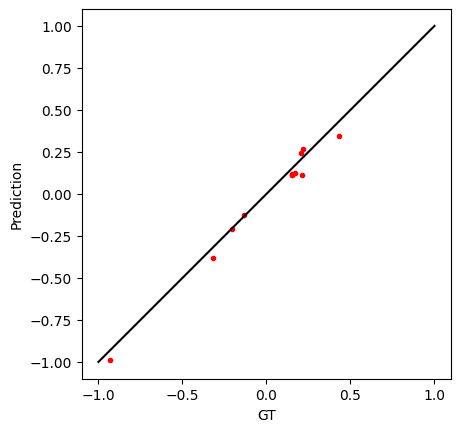

OC12CN3C1C2CC3=O NC(=O)C1C2OC1C=C2
SMILES result= OC12CN3C1C2CC3=O GT:  NC(=O)C1C2OC1C=C2  is novel:  False


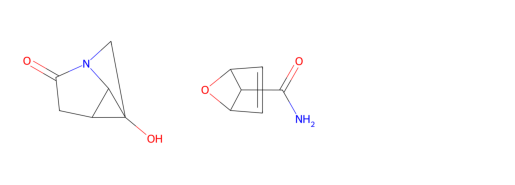

Properties:  [[-0.7528697  -0.29214564  0.0760262  -0.02710762 -0.2153366  -0.3462469
  -0.33508238  0.25414357 -0.02347806 -0.02194673 -0.02599609 -0.0282564 ]
 [-0.6501972  -0.30249345  0.3085658   0.00203414 -0.31016213 -0.4112352
  -0.27283186  0.06892331 -0.10107979 -0.10226773 -0.0943722  -0.10127294]]  unscaled:  [[ 3.65214062e+00  7.36658859e+01 -2.52723515e-01  4.25542053e-03
   2.59018183e-01  1.11591711e+03  1.01723045e-01  3.16912498e+01
  -3.85436646e+02 -3.84915070e+02 -3.86278931e+02 -3.87074249e+02]
 [ 5.16945553e+00  7.26812363e+01 -2.14714929e-01  9.62479040e-03
   2.30689064e-01  1.00687476e+03  1.09753147e-01  2.78972912e+01
  -4.11591919e+02 -4.11986633e+02 -4.09324585e+02 -4.11684601e+02]]
R2 score=  0.8146854475198063


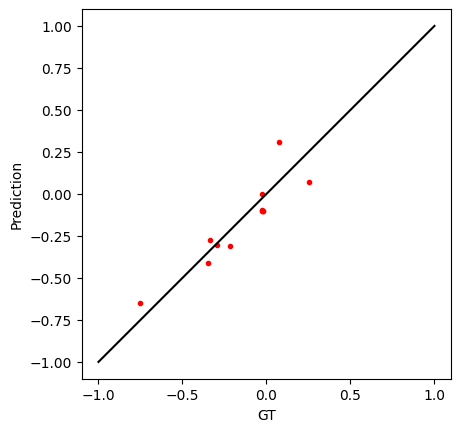

CC1CCC(C)(C)COHC1 CC1CCC(C)(O)CC1
SMILES result= CC1CCC(C)(C)COHC1 GT:  CC1CCC(C)(O)CC1  is novel:  True


[06:35:21] SMILES Parse Error: syntax error while parsing: CC1CCC(C)(C)COHC1
[06:35:21] SMILES Parse Error: Failed parsing SMILES 'CC1CCC(C)(C)COHC1' for input: 'CC1CCC(C)(C)COHC1'


Properties:  [[-1.0017313  -0.11934716  0.1781132   0.36871284 -0.02734041 -0.19699976
   0.5664996   0.5296619   0.07557146  0.07729498  0.07230338  0.07450731]
 [-0.98777    -0.09765804  0.17364469  0.35468972 -0.03096936 -0.27721724
   0.45449036  0.3755946   0.08693457  0.09429727  0.08598291  0.08498644]]  unscaled:  [[-2.5585150e-02  9.0108521e+01 -2.3603739e-01  7.7185340e-02
   3.1518206e-01  1.3663354e+03  2.1802396e-01  3.7334827e+01
  -3.5205252e+02 -3.5146646e+02 -3.5314789e+02 -3.5243753e+02]
 [ 1.8073708e-01  9.2172348e+01 -2.3676777e-01  7.4601583e-02
   3.1409791e-01  1.2317404e+03  2.0357516e-01  3.4178993e+01
  -3.4822269e+02 -3.4573596e+02 -3.4853729e+02 -3.4890555e+02]]
R2 score=  0.975632520449532


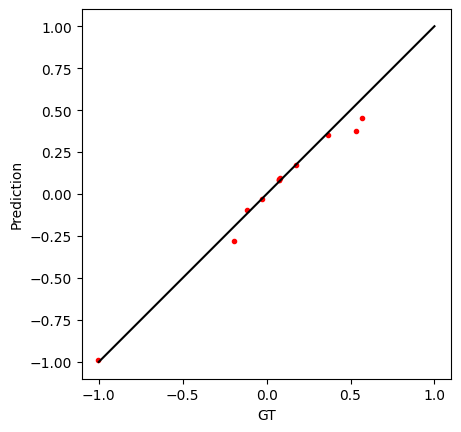

C(C1CC1)C1C2CCC12 C(C1CC1)C1CC2CC12
SMILES result= C(C1CC1)C1C2CCC12 GT:  C(C1CC1)C1CC2CC12  is novel:  False


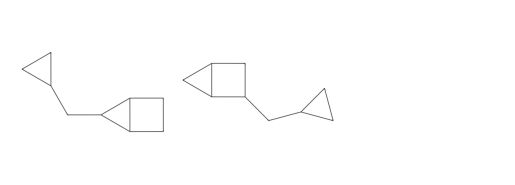

Properties:  [[-0.9618367  -0.08785183  0.3756683   0.00471825 -0.36088243 -0.25488135
   0.2536564   0.3170774   0.09038048  0.09483378  0.10113831  0.10199212]
 [-0.9986315  -0.06282503  0.36641628 -0.0125717  -0.35200194 -0.30840448
   0.22976178  0.32218057  0.11100196  0.11406793  0.11550421  0.10695733]]  unscaled:  [[ 5.6398493e-01  9.3105461e+01 -2.0374702e-01  1.0119338e-02
   2.1553637e-01  1.2692173e+03  1.7766829e-01  3.2980354e+01
  -3.4706122e+02 -3.4555511e+02 -3.4342932e+02 -3.4317374e+02]
 [ 2.0224301e-02  9.5486885e+01 -2.0525926e-01  6.9336644e-03
   2.1818942e-01  1.1794121e+03  1.7458597e-01  3.3084888e+01
  -3.4011090e+02 -3.3907242e+02 -3.3858740e+02 -3.4150021e+02]]
R2 score=  0.9952621452744418


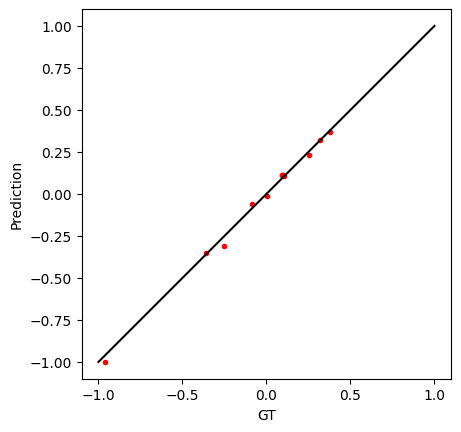

CC112OCC1)C1C2CN23 CC12C3C=CC(C1O)N23
SMILES result= CC112OCC1)C1C2CN23 GT:  CC12C3C=CC(C1O)N23  is novel:  True


[06:35:37] SMILES Parse Error: extra close parentheses while parsing: CC112OCC1)C1C2CN23
[06:35:37] SMILES Parse Error: Failed parsing SMILES 'CC112OCC1)C1C2CN23' for input: 'CC112OCC1)C1C2CN23'


Properties:  [[-0.8999839  -0.23997898  0.39285335 -0.34198257 -0.5706653  -0.41656473
  -0.12726375  0.07423654 -0.03552001 -0.0373397  -0.03064352 -0.03687889]
 [-0.79994506 -0.21511753  0.22962664  0.00626549 -0.27171606 -0.40879038
   0.10549281  0.21064276 -0.02041029 -0.02003223 -0.01956946 -0.01802177]]  unscaled:  [[ 1.4780582e+00  7.8629799e+01 -2.0093814e-01 -5.3760290e-02
   1.5286374e-01  9.9793256e+02  1.2853092e-01  2.8006123e+01
  -3.8949530e+02 -3.9010315e+02 -3.8784534e+02 -3.8998044e+02]
 [ 2.9564519e+00  8.0995491e+01 -2.2761752e-01  1.0404416e-02
   2.4217483e-01  1.0109769e+03  1.5855570e-01  3.0800201e+01
  -3.8440268e+02 -3.8426981e+02 -3.8411288e+02 -3.8362463e+02]]
R2 score=  0.7395432294467232


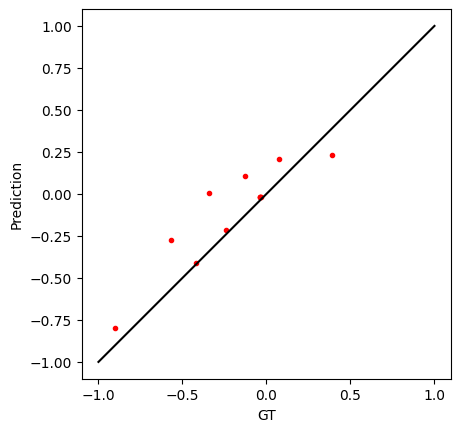

OC1CCC(=O)C=CC1 OC1CCC(=O)C=CC1
SMILES result= OC1CCC(=O)C=CC1 GT:  OC1CCC(=O)C=CC1  is novel:  False


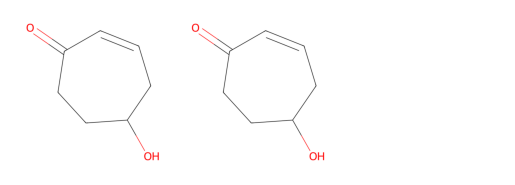

Properties:  [[-0.6768616  -0.22446857  0.04781166 -0.00514722 -0.18413505 -0.24119134
  -0.02664146  0.37335518  0.00780272  0.01305253  0.01245526  0.01059764]
 [-0.8006062  -0.23012699  0.04862877  0.06705629 -0.15411013 -0.16936347
  -0.03615146  0.3748545  -0.04276894 -0.03978039 -0.03555364 -0.04420039]]  unscaled:  [[ 4.7754040e+00  8.0105690e+01 -2.5733519e-01  8.3016250e-03
   2.6833963e-01  1.2921874e+03  1.4151086e-01  3.4133121e+01
  -3.7489365e+02 -3.7311884e+02 -3.7331921e+02 -3.7397839e+02]
 [ 2.9466815e+00  7.9567268e+01 -2.5720164e-01  2.1605121e-02
   2.7730960e-01  1.4127057e+03  1.4028409e-01  3.4163834e+01
  -3.9193854e+02 -3.9092578e+02 -3.8950024e+02 -3.9244818e+02]]
R2 score=  0.9448035665255785


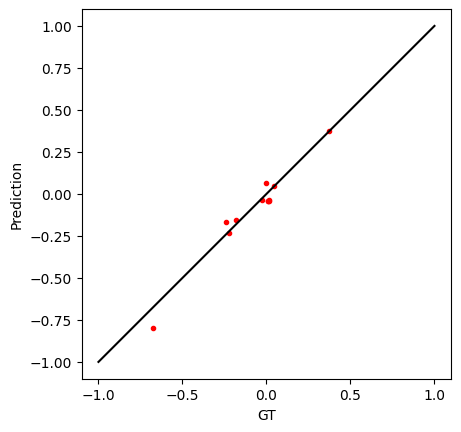

N#CC1COC2CC1C23 N#CC1CN2CC(C2)N1
SMILES result= N#CC1COC2CC1C23 GT:  N#CC1CN2CC(C2)N1  is novel:  True


[06:35:54] SMILES Parse Error: unclosed ring for input: 'N#CC1COC2CC1C23'


Properties:  [[-0.6511987  -0.22862191  0.07442064 -0.2839617  -0.3935272  -0.28875932
  -0.34277493  0.17498714  0.01007226  0.00755822  0.00533303  0.00647652]
 [-0.79614776 -0.30665284 -0.03060657  0.11359287 -0.07218876 -0.44329703
  -0.14133708 -0.01080961  0.12364343  0.12346407  0.12647413  0.13486113]]  unscaled:  [[ 5.1546555e+00  7.9710480e+01 -2.5298595e-01 -4.3069944e-02
   2.0578375e-01  1.2123743e+03  1.0073074e-01  3.0069849e+01
  -3.7412872e+02 -3.7497067e+02 -3.7571973e+02 -3.7536746e+02]
 [ 3.0125692e+00  7.2285446e+01 -2.7015266e-01  3.0179486e-02
   3.0178362e-01  9.5307898e+02  1.2671551e-01  2.6264082e+01
  -3.3585016e+02 -3.3590552e+02 -3.3489008e+02 -3.3209518e+02]]
R2 score=  0.29325736552178605


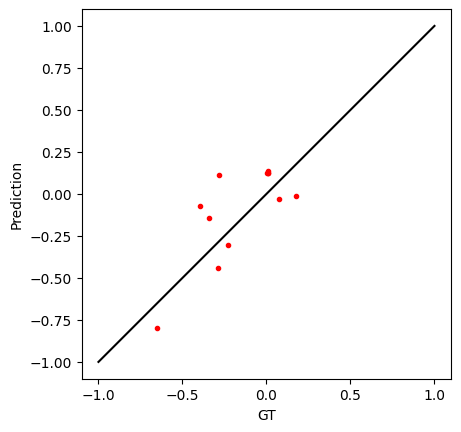

Cn1cc(nc1C#C)O CNc1c([nH]nn1)C#C
SMILES result= Cn1cc(nc1C#C)O GT:  CNc1c([nH]nn1)C#C  is novel:  False


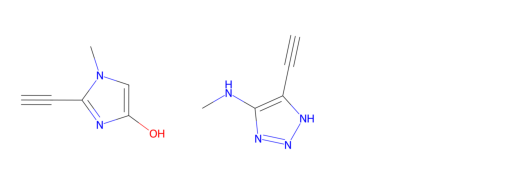

Properties:  [[-0.7961981  -0.324318    0.02469852 -0.23336998 -0.32819098 -0.26252252
  -0.300478    0.06997514 -0.15387589 -0.15673026 -0.15653223 -0.1630402 ]
 [-0.74718064 -0.39702237 -0.14713572 -0.20805259 -0.21488766 -0.23880087
  -0.523037    0.0400577  -0.22068809 -0.23394959 -0.22308247 -0.22444199]]  unscaled:  [[ 3.0118248e+00  7.0604523e+01 -2.6111302e-01 -3.3748418e-02
   2.2530295e-01  1.2563962e+03  1.0618689e-01  2.7918835e+01
  -4.2938651e+02 -4.3034280e+02 -4.3027512e+02 -4.3250336e+02]
 [ 3.7362151e+00  6.3686337e+01 -2.8919932e-01 -2.9083690e-02
   2.5915229e-01  1.2961984e+03  7.7477559e-02  2.7306021e+01
  -4.5190524e+02 -4.5636896e+02 -4.5270535e+02 -4.5319894e+02]]
R2 score=  0.769086657706677


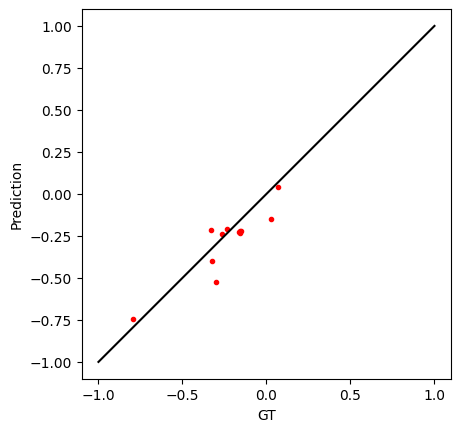

OC1CCC(C#C)(1)OC COC1(COC1)CC#C
SMILES result= OC1CCC(C#C)(1)OC GT:  COC1(COC1)CC#C  is novel:  True


[06:36:10] SMILES Parse Error: syntax error while parsing: OC1CCC(C#C)(1)OC
[06:36:10] SMILES Parse Error: Failed parsing SMILES 'OC1CCC(C#C)(1)OC' for input: 'OC1CCC(C#C)(1)OC'


Properties:  [[-0.9065264  -0.24652135  0.18683597  0.13390243 -0.17101851 -0.28553787
   0.03208793  0.36496404 -0.09492159 -0.09170622 -0.09218621 -0.09086506]
 [-0.86539847 -0.2835992   0.10196099  0.28097185 -0.04067395 -0.36668596
   0.10807183  0.32029536 -0.12096852 -0.12479283 -0.12102086 -0.12146804]]  unscaled:  [[ 1.3813717e+00  7.8007263e+01 -2.3461168e-01  3.3921525e-02
   2.7225822e-01  1.2177794e+03  1.4908673e-01  3.3961239e+01
  -4.0951630e+02 -4.0842694e+02 -4.0858777e+02 -4.0817661e+02]
 [ 1.9891684e+00  7.4479118e+01 -2.4848446e-01  6.1019067e-02
   3.1119865e-01  1.0816229e+03  1.5888840e-01  3.3046268e+01
  -4.1829526e+02 -4.1957852e+02 -4.1830627e+02 -4.1849136e+02]]
R2 score=  0.9382753617882681


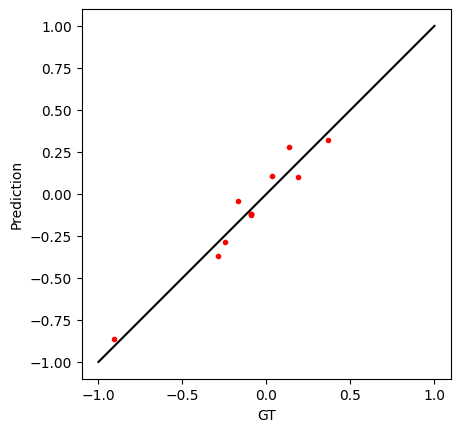

CC1COC(C)C(C)C-23 CC1CC=CCOC1C
SMILES result= CC1COC(C)C(C)C-23 GT:  CC1CC=CCOC1C  is novel:  True


[06:36:19] SMILES Parse Error: unclosed ring for input: 'CC1COC(C)C(C)C-23'


Properties:  [[-0.9733031  -0.135325    0.23471966  0.21866266 -0.16702889 -0.24375845
   0.3179419   0.4884133   0.03336044  0.02648683  0.02490878  0.02780889]
 [-0.90786314 -0.17198385  0.28684324  0.3496205  -0.10511922 -0.3194919
   0.30716762  0.33399236  0.01687829  0.01953672  0.02183989  0.01562673]]  unscaled:  [[ 3.9453244e-01  8.8588150e+01 -2.2678506e-01  4.9538594e-02
   2.7345011e-01  1.2878801e+03  1.8596089e-01  3.6489914e+01
  -3.6627954e+02 -3.6859091e+02 -3.6912183e+02 -3.6817734e+02]
 [ 1.3616170e+00  8.5099876e+01 -2.1826547e-01  7.3667578e-02
   2.9194564e-01  1.1608087e+03  1.8457104e-01  3.3326832e+01
  -3.7183475e+02 -3.7093341e+02 -3.7015619e+02 -3.7228336e+02]]
R2 score=  0.9602502798092539


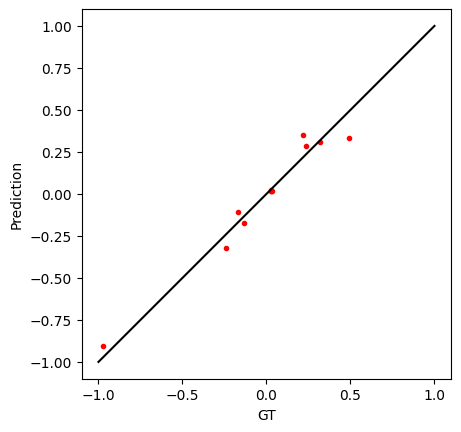

Cc1cc[nH]c1C(=O)NHNH1 Cc1[nH]nc(n1)C(=N)N
SMILES result= Cc1cc[nH]c1C(=O)NHNH1 GT:  Cc1[nH]nc(n1)C(=N)N  is novel:  True


[06:36:27] SMILES Parse Error: syntax error while parsing: Cc1cc[nH]c1C(=O)NHNH1
[06:36:27] SMILES Parse Error: Failed parsing SMILES 'Cc1cc[nH]c1C(=O)NHNH1' for input: 'Cc1cc[nH]c1C(=O)NHNH1'


Properties:  [[-0.5068841  -0.30573708  0.11182187 -0.0162427  -0.25052336 -0.16301127
  -0.24537101  0.15396    -0.14815794 -0.14539297 -0.15448615 -0.15037204]
 [-0.8327158  -0.30569655  0.12073582 -0.24803446 -0.38581574 -0.1950457
  -0.38429153  0.06762739 -0.18773378 -0.19252975 -0.18273017 -0.18606901]]  unscaled:  [[ 7.28736544e+00  7.23725891e+01 -2.46872708e-01  6.25728304e-03
   2.48506144e-01  1.42336389e+03  1.13295496e-01  2.96391392e+01
  -4.27459351e+02 -4.26521667e+02 -4.29585480e+02 -4.28233551e+02]
 [ 2.47215915e+00  7.23764420e+01 -2.45415732e-01 -3.64503488e-02
   2.08087549e-01  1.36961414e+03  9.53752398e-02  2.78707466e+01
  -4.40798157e+02 -4.42408752e+02 -4.39104919e+02 -4.40265259e+02]]
R2 score=  0.3942386996775591


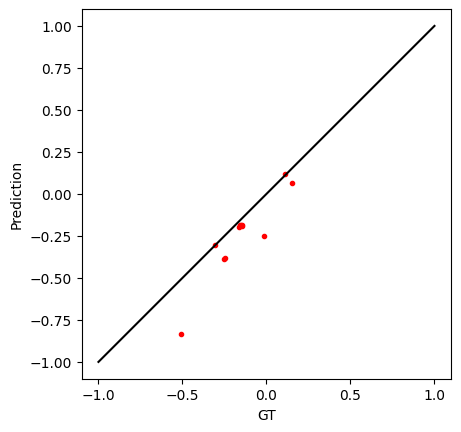

O=C(C#C)C1CN=NC23 O=C1C=CC(=O)C1C#C
SMILES result= O=C(C#C)C1CN=NC23 GT:  O=C1C=CC(=O)C1C#C  is novel:  True


[06:36:35] SMILES Parse Error: unclosed ring for input: 'O=C(C#C)C1CN=NC23'


Properties:  [[-0.8191275  -0.31434909  0.2312125  -0.29704186 -0.49250203 -0.46636567
  -0.27655306 -0.00892995 -0.11888982 -0.12380014 -0.12147939 -0.11996161]
 [-0.6272325  -0.32809976  0.08185293 -0.30310744 -0.3871849  -0.43465093
  -0.3183333  -0.05591658 -0.07803115 -0.08208607 -0.08342484 -0.07775741]]  unscaled:  [[ 2.6729701e+00  7.1553116e+01 -2.2735831e-01 -4.5479961e-02
   1.7621502e-01  9.1437274e+02  1.0927312e-01  2.6302582e+01
  -4.1759467e+02 -4.1924396e+02 -4.1846082e+02 -4.1798364e+02]
 [ 5.5088329e+00  7.0244667e+01 -2.5177112e-01 -4.6597544e-02
   2.0767851e-01  9.6758612e+02  1.0388362e-01  2.5340134e+01
  -4.0382346e+02 -4.0518457e+02 -4.0563486e+02 -4.0375864e+02]]
R2 score=  0.8964537444954859


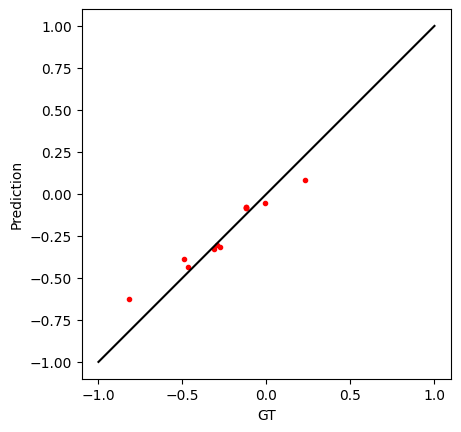

C1CN(C1)C(=O)C#N O=CC1NCC1C#N
SMILES result= C1CN(C1)C(=O)C#N GT:  O=CC1NCC1C#N  is novel:  False


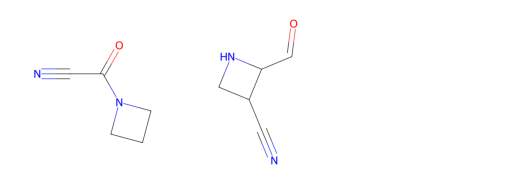

Properties:  [[-0.6753826  -0.3956734   0.01840038 -0.14234991 -0.26930666 -0.45379412
  -0.38109022 -0.04114513  0.06520304  0.06143387  0.05652504  0.06632601]
 [-0.75410086 -0.3298559   0.09649667 -0.13153434 -0.2870957  -0.42141446
  -0.22995692  0.01868453 -0.10952567 -0.11330626 -0.10722561 -0.11610672]]  unscaled:  [[ 4.7972608e+00  6.3814697e+01 -2.6214245e-01 -1.6977971e-02
   2.4289463e-01  9.3546619e+02  9.5788196e-02  2.5642704e+01
  -3.5554715e+02 -3.5681229e+02 -3.5846585e+02 -3.5519507e+02]
 [ 3.6339467e+00  7.0077568e+01 -2.4937762e-01 -1.4985203e-02
   2.3758015e-01  9.8979529e+02  1.1528386e-01  2.6868223e+01
  -4.1443854e+02 -4.1570709e+02 -4.1365671e+02 -4.1668433e+02]]
R2 score=  0.7666308221900848


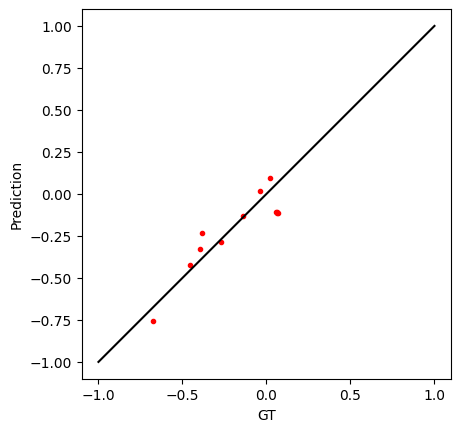

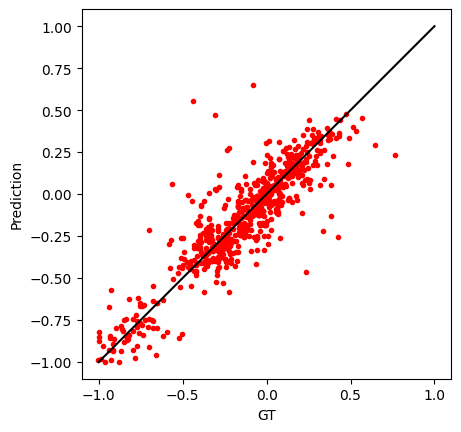

R2 score_overall=  0.7782835704058095
Fraction of novel structures:  0.21951219512195122 9 out of 41


In [47]:
sample_loop_transformer (model,device,
             test_loader,model_forward=model_forward,
             cond_scales=[1,], #list of cond scales - each sampled...
             num_samples=64, #how many samples produced every time tested.....
             tokens_to_generate=max_length-1,show_jointplot=True ,
             draw_molecules=True,
             temperature=1., #gumbal sampling temp
             start_char_token=start_char_token, end_char_token=end_char_token,
             start_char=start_char, end_char=end_char,
             tokenizer_X=tokenizer_X, scaler=scaler,
             ALL_SMILES=ALL_SMILES, prefix=prefix,X_norm_factor=X_norm_factor,
             )

In [ ]:
if train_transformer:

    loss_list=[]

    loss_list = train_loop_transformer (model,
                    train_loader,test_loader,device,
                    optimizer=optimizer, 
                    model_forward=model_forward,
                    print_every=1000,
                    epochs= 3000000,
                    start_ep=0,
                    start_step=0,
                    print_loss=1*len (train_loader),
                    cond_scales=[1.],
                    tokens_to_generate=max_length-1,
                    clamp=False,
                    save_model=True,
                    show_jointplot=True,
                    draw_molecules=True,
                    num_samples=6,
                    start_char_token=start_char_token, end_char_token=end_char_token,
                    start_char=start_char, end_char=end_char,
                    tokenizer_X=tokenizer_X, scaler=scaler,
                    ALL_SMILES=ALL_SMILES, prefix=prefix, X_norm_factor=X_norm_factor,
                   )